# Load dependencies and define functions

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import pylab
import analyze_movements as am
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import cm
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib as mpl
from itertools import compress
import seaborn as sns
from scipy import signal,stats
from tqdm.notebook import trange, tqdm
import matplotlib.colors as mpc
import pylab
import cv2
from itertools import product, compress
import fnmatch
import statsmodels.api as sm
from statsmodels.formula.api import ols
import warnings
warnings.filterwarnings('ignore')

import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, r'C:\Users\nlab\Desktop\GitHub Code\jumping_behavior')
import io_dict_to_hdf5 as ioh5
import util


### Set general plotting parameters
plt.rcParams.update({'font.size': 15})
plot_params = {'cm':pylab.get_cmap('jet'),
               'pointsize':3,
               'cond_col':['k',[0.6,0.6,0.6]],
               'hmm_col':[[0.6,0.6,0.6], 'k'],
               '4cond_col':[[1,0,0],'k',[0.5,0,0],[0.6,0.6,0.6]],
               'cond_sty':['-',':'],
               '4cond_sty':[':','-',':','-'],
               'plat_cols':['b','r','m']}

save_pdf = False
pp = []
        
print('finished loading dependencies')

finished loading dependencies


# Load ARHMM data and make group/individual PDFs of states/performance

In [10]:
KDir

'T:\\jumping_revisions_arhmm\\SideView_elifeRevis5\\sticky-ARHMM_lag-1_dsf-3_kappa-1e+04_2022-06-16_0002_7\\K-07'

In [11]:
# time_per = 2
# model = r'T:\Last_%ds\sticky-ARHMM_lag-1_dsf-2_kappa-1e+04_2021-04-05_1201' % time_per
side = 'Side'
time_per = 5 # 2 or 5 (s)

if time_per==5:
    model_path = r'T:\jumping_revisions_arhmm\%sView_elifeRevis5\sticky-ARHMM_lag-1_dsf-3_kappa-1e+04_2022-06-17_0002_' % side
else:
    model_path = r'T:\jumping_revisions_arhmm\%sView_elifeRevis2\sticky-ARHMM_lag-1_dsf-3_kappa-1e+04_2022-06-10_2103_' % side

# model = r'T:\Last_%ds_Nov2020\sticky-ARHMM_lag-1_dsf-2_kappa-1e+04_2021-04-04_2033' % time_per
# model = r'T:\Last_5s_varplat\sticky-ARHMM_lag-1_dsf-2_kappa-1e+04_Kmin-6_Kmax-16_2021-08-18_1542'

# time_per = 5
# model = r'T:\Last_%ds_noaborts\sticky-ARHMM_lag-1_dsf-2_kappa-1e+04_10_2021-04-08_1557' % time_per

Performance = 1
ts_down = 3
st_pt = 2
end_pt = -2
n_rand=60
cond_lab = 'ocular'
state_key_vals = 'hmm_seq'
state_key_times = 'hmm_times'

bin_min = -time_per
bin_step = 0.5
# im_range = [475,575,350,250] #range of mouse image to plot states over
if side=='Side':
    im_range = [375*2,575*2,375*2,175*2] #range of mouse image to plot states over
else:
    im_range = [450*2,600*2,325*2,175*2] #range of mouse image to plot states over



# cycle through models
# Krange = np.arange(7,17)
Krange = np.arange(2,17)
# Krange = [6]
# kind=0

for kind,K in enumerate(Krange):
##indent all below if doing loop

    print('doing model %d of %d' % (kind+1, len(Krange)))

    model = model_path + str(K)

    st_list=np.arange(K)
    # st_remap = [1,3,5,2,4] #K=6
    # st_remap = [0,1,2,3,4,5,6,7,8,9] #K=10
    st_remap = np.arange(K)

    #LOAD ARHMM DATA
    KDir = os.path.join(model,'K-%s' % str(K).zfill(2))
    fpath = glob(os.path.join(KDir,'MAP_seqs*.h5'))[0]
    trMAPs, trPosteriors, trMasks, arhmm_params, opt = ioh5.load_MAP_seqs_h5(fpath)

    trMasks2 = []
    tBins_removed = []
    for iTrial, mapseq in enumerate(trMAPs):
        #Apply posterior probability threshold mask
        MAPcp = mapseq.copy()
        mask = trMasks[iTrial]
        MAPcp[~mask] = -1
        #Loop over states and NaN out that were less than 100ms (3 frames)
        for state in range(K):
            state_1hot = np.concatenate(([0],(np.array(MAPcp) == state).astype(int),[0]))
            state_trans = np.diff(state_1hot)
            state_ends = np.nonzero(state_trans == -1)[0]
            state_starts = np.nonzero(state_trans == +1)[0]
            state_durations = state_ends - state_starts
            #State was not used this trial
            if len(state_durations) == 0:
                continue
            #Loop over the individual state sequences and NaN out the short ones
            for iSeq, sd in enumerate(state_durations):
                if sd <= 3: #3 frames, so 90ms for 2x downsampled data
                    MAPcp[slice(state_starts[iSeq],state_ends[iSeq])] = -1
        #Update mask
        mask2 = MAPcp != -1
        trMasks2.append(mask2)
        #See how much of a difference that made
        tBins_removed.append(np.sum(mask)-np.sum(mask2))

    #Load metadata/DLC data
    data_df1 = pd.read_hdf(r'T:\jumping_revisions_analysis\df_decision_alldata_%s.h5' % side)
    df_all = data_df1.copy()
    # remove trials with NaN values for nose/eye/ear/takeoff
    good_trials = []
    for index,row in df_all.iterrows():
        nose = np.sum(np.isnan(row[side + ' Nose x']))==0
        eye = np.sum(np.isnan(row[side + ' LEye x']))==0
        ear = np.sum(np.isnan(row[side + ' LEar x']))==0
        plat = np.sum(np.isnan(row[side + ' TakeFL x']))==0

        if nose & eye & ear & plat:
            good_trials.append(index)
    good_trials = np.array(good_trials)
    print('removed %d trials for NaNs' % (len(df_all)-len(good_trials)))

    df_all = df_all.iloc[good_trials]
    df_all.reset_index(inplace=True,drop=True)
    # data_df2 = pd.read_hdf(r'T:\single_platform_data.h5')
    # df_all = pd.concat((data_df1,data_df2),ignore_index=True)

    # #correct for distance jumped based on overhang of animal off platform edge
    # jd_sub = []
    # actual_distance = []
    # for idx,row in df_all.iterrows():
    #     TakeFL_x = np.nanmedian(row['Top TakeFL x'])
    #     LandFR_x = np.nanmedian(row['Top LandFR x'])
    #     LandFL_x = np.nanmedian(row['Top LandFL x'])
    #     actual_distance.append((TakeFL_x - np.nanmean([LandFR_x,LandFL_x]))/row['Top_pixpercm'])

    #     jd_sub.append((row['Top TakeFL x'][-1] - row['Top LEye x'][-1])/row['Top_pixpercm'])
    # df_all['actual_distance'] = actual_distance
    # df_all['jumpdist'] = df_all['jumpdist'] + jd_sub
    # df_all['accuracy'] = np.abs(df_all['jumpdist'].to_numpy() - df_all['actual_distance'].to_numpy())

    #     ### REMOVE ABORTS FOR CERTAIN MODELS
    #     #Load metadata/DLC data
    #     data_df1 = pd.read_hdf(r'T:\single_platform_data.h5')
    #     data_df2 = pd.read_hdf(r'T:\variable_platform_data.h5')
    #     df_all = pd.concat((data_df1,data_df2),ignore_index=True)
    #     df_all = am.remove_aborts(df_all)
    #     del df_all['index']

    #Add arhmm labels to dataframe

    # trMAPs = trMAPs[:df_all.shape[0]]
    # trPosteriors = trPosteriors[:df_all.shape[0]]
    # trMasks2 = trMasks2[:df_all.shape[0]]

    df_all['trMAPs'] = trMAPs
    df_all['trPosteriors'] = trPosteriors
    df_all['trMasks'] = trMasks2 # note which version of masking you want

    #calculate a bunch of stats for arhmm data for each trial and add them to the dataframe
    tmp = np.zeros(df_all.shape[0])
    tmp[:] = np.nan
    hmm_cols = ['hmm_%d_freq','hmm_%d_totdur','hmm_%d_avgdur','hmm_%d_xamp','hmm_%d_yamp','hmm_%d_xvel','hmm_%d_yvel','hmm_%d_visangle']
    hmm_ylims = [5,2,1,3,3,10,10,10] #max y value for plotting
    for col in hmm_cols:
        for hmm_k in range(K):
            df_all[col % hmm_k] = tmp

    hmm_seq,hmm_ind,hmm_times,trial_dur = ([] for i in range(4))
    for idx,row in df_all.iterrows():
        maps = row['trMAPs'] #raw states
        masks = row['trMasks'] #filter to ditch low prob/short duration states
        st_lab = maps.copy()
        st_lab[~masks] = -1 #relabel bad states as -1
        n_seq,goods,inds = am.get_arhmm_start_frames(st_lab) #get number state sequences and indices of state starts
        hmm_seq.append(goods)
        hmm_ind.append(inds)

        xtr,ytr = am.filter_decision_period(row,side,'LEye',0.95,ts_down,time_per,st_pt,end_pt) #filter decision period data
        xtr = xtr/row[side + '_pixpercm'] #convert from pix to cm
        ytr = ytr/row[side + '_pixpercm'] #convert from pix to cm
        td = len(xtr) #trial duration in frames
        trial_dur.append(td/(row['fps']/ts_down)) #trial duration in sec
        hmm_times.append((inds-td)/(row['fps']/ts_down)) #state starts in time relative to jump instead of frames

        #loop through states to calculate various statistics
        for hmm_k in range(K):
            n_seq, seqs = am.split_seqs(np.where(st_lab==hmm_k)[0]) #get state indices
            df_all['hmm_%d_freq' % hmm_k].iloc[idx] = n_seq #state frequency
            if n_seq>0:
                st_dur, st_xamp, st_yamp, st_xvel, st_yvel, st_vis = ([] for i in range(6))
                for n,seq in enumerate(seqs):
                    try:
                        st_dur.append(len(seq)/(row['fps']/ts_down))

                        xamp = np.abs(xtr[seq[-1]]-xtr[seq[0]])
                        st_xamp.append(xamp)
                        st_xvel.append(xamp/(len(seq)/(row['fps']/ts_down)))

                        yamp = np.abs(ytr[seq[-1]]-ytr[seq[0]])
                        st_yamp.append(yamp)
                        st_yvel.append(yamp/(len(seq)/(row['fps']/ts_down)))

                        st_vis.append(np.round(np.degrees(np.arctan(yamp/row['distance'])),1))
                    except:
                        pass

                df_all['hmm_%d_totdur' % hmm_k].iloc[idx] = np.sum(np.array(st_dur)) #total state duration
                df_all['hmm_%d_avgdur' % hmm_k].iloc[idx] = np.mean(np.array(st_dur)) #average state duration
                df_all['hmm_%d_xamp' % hmm_k].iloc[idx] = np.mean(np.array(st_xamp)) #average x amplitude
                df_all['hmm_%d_yamp' % hmm_k].iloc[idx] = np.mean(np.array(st_yamp)) #average y amplitude
                df_all['hmm_%d_xvel' % hmm_k].iloc[idx] = np.mean(np.array(st_xvel)) #average x velocity
                df_all['hmm_%d_yvel' % hmm_k].iloc[idx] = np.mean(np.array(st_yvel)) #average y velocity
                df_all['hmm_%d_visangle' % hmm_k].iloc[idx] = np.mean(np.array(st_vis)) #average visual angle

    df_all['hmm_seq'] = hmm_seq #state sequences
    df_all['hmm_ind'] = hmm_ind #start indices of states
    df_all['hmm_times'] = hmm_times #start times of states relative to jump
    df_all['trial_dur'] = trial_dur #decision period duration

    print('finished loading data!')

    ### select the group you want to analyze
    hmm_ylims = [3,2,1,2,2,10,10,12] #max y value for plotting

    ### select variable platform group (baseline)
    group_name = 'variable_baseline'
    condition = 'ocular'
    vid_dir = r'T:\jumping_revisions'
    base_df = df_all.copy()
    base_df = base_df[(base_df['condition']=='control') | (base_df['condition']=='suture')]
    # base_df = base_df[(base_df['success']!=2)]
    # base_df = base_df[base_df['laser_trial']=='laser off']
    base_df.reset_index(inplace=True,drop=True)
    # base_df[base_df['condition']=='opto suture'] = base_df[base_df['condition']=='opto suture'].replace('opto suture','suture')
    #remove platform 1
    # base_df = base_df[base_df['platform']!=1]
    # base_df.reset_index(inplace=True,drop=True)
    print('%d trials total' % len(base_df))
    anis = np.unique(base_df['subject'])
    dists = np.unique(base_df['distance_DLC'])
    conds = np.unique(base_df['condition'])


    # ### select variable platform group (control opto)
    # group_name = 'variable_opto_ctrl'
    # condition = 'laser_trial'
    # vid_dir = r'\\sendak\D\Phil\jumping_analysis\paper_cohort\clipped_vids'
    # base_df = df_all.copy()
    # base_df = base_df[(base_df['condition']=='opto suture')]
    # base_df.reset_index(inplace=True,drop=True)
    # base_df = base_df[base_df['subject'].str.contains('J')]
    # base_df.reset_index(inplace=True,drop=True)
    # print('%d trials total' % len(base_df))

    # ### select variable platform group (expt opto)
    # group_name = 'variable_opto_expt'
    # condition = 'laser_trial'
    # vid_dir = r'\\sendak\D\Phil\jumping_analysis\paper_cohort\clipped_vids'
    # base_df = df_all.copy()
    # base_df = base_df[(base_df['condition']=='opto suture')]
    # base_df.reset_index(inplace=True,drop=True)
    # base_df = base_df[base_df['subject'].str.contains('PV')]
    # base_df.reset_index(inplace=True,drop=True)
    # print('%d trials total' % len(base_df))


    # ### select single platform group (baseline)
    # group_name = 'single_baseline'
    # condition = 'ocular'
    # vid_dir = r'\\jumpy\T\Phil\jumping_analysis\RIS_cohort'
    # base_df = df_all.copy()
    # base_df = base_df[(base_df['condition']=='RIS control') | (base_df['condition']=='RIS opto suture')]
    # base_df = base_df[base_df['laser_trial']=='laser off']
    # base_df.reset_index(inplace=True,drop=True)
    # base_df[base_df['condition']=='RIS opto suture'] = base_df[base_df['condition']=='RIS opto suture'].replace('RIS opto suture','RIS suture')
    # print('%d trials total' % len(base_df))


    # ### select single platform group (control opto)
    # group_name = 'single_opto'
    # condition = 'laser_trial'
    # vid_dir = r'\\jumpy\T\Phil\jumping_analysis\RIS_cohort'
    # base_df = df_all.copy()
    # base_df = base_df[(base_df['condition']=='RIS opto suture')]
    # base_df.reset_index(inplace=True,drop=True)
    # base_df[base_df['condition']=='opto suture'] = base_df[base_df['condition']=='opto suture'].replace('opto suture','suture')
    # base_df = base_df[base_df['subject'].str.contains('J')]
    # base_df.reset_index(inplace=True,drop=True)
    # print('%d trials total' % len(base_df))


    # ### select single platform group (expt opto)
    # group_name = 'single_opto'
    # condition = 'laser_trial'
    # vid_dir = r'\\jumpy\T\Phil\jumping_analysis\RIS_cohort'
    # base_df = df_all.copy()
    # base_df = base_df[(base_df['condition']=='RIS opto suture')]
    # base_df.reset_index(inplace=True,drop=True)
    # base_df[base_df['condition']=='opto suture'] = base_df[base_df['condition']=='opto suture'].replace('opto suture','suture')
    # base_df = base_df[base_df['subject'].str.contains('PV')]
    # base_df.reset_index(inplace=True,drop=True)
    # print('%d trials total' % len(base_df))

    ### Exporting data for Wyrick

    # ### select all baseline groups
    # base_df = df_all.copy()
    # base_df = base_df[base_df['laser_trial']=='laser off']
    # base_df.reset_index(inplace=True,drop=True)
    # base_df[base_df['condition']=='opto suture'] = base_df[base_df['condition']=='opto suture'].replace('opto suture','suture')
    # base_df[base_df['condition']=='RIS opto suture'] = base_df[base_df['condition']=='RIS opto suture'].replace('RIS opto suture','RIS suture')
    # print('%d trials total' % len(base_df))
    # print(np.unique(base_df['condition']),np.unique(base_df['laser_trial']))
    # base_df.to_hdf(r'T:\arhmm_baseline_comparison.h5',key='df',mode='w')

    # ### select all opto groups
    # base_df = df_all.copy()
    # base_df = base_df[(base_df['condition']=='RIS opto suture') | (base_df['condition']=='opto suture')]
    # base_df.reset_index(inplace=True,drop=True)
    # print('%d trials total' % len(base_df))
    # print(np.unique(base_df['condition']),np.unique(base_df['laser_trial']))
    # base_df.to_hdf(r'T:\arhmm_opto_comparison.h5',key='df',mode='w')

    # print('finished saving!')

    ### make group PDF
    print('making pdfs for group %s model K=%d' % (group_name,K))
    pdf_file = r'T:\jumping_revisions_arhmm\arhmm_%s %dsec_K-%s.pdf' % (side,time_per,str(K).zfill(2))
    pp = PdfPages(pdf_file)

    am.plot_subset_all_states(base_df,K,side,st_remap,n_rand,ts_down,time_per,st_pt,end_pt,vid_dir,im_range,True,pp)
    plt_types = ['freq','yamp','visangle']
    plt_lims = [1,1,1]
    am.plot_state_freq_difference(base_df,st_remap,plt_types,plt_lims,time_per,condition,True,pp)

    # base_df = base_df[base_df['distance']==16]
    # base_df.reset_index(inplace=True)

    for h,hmm_k in enumerate(st_remap):
#         print('doing state %d' % (h+1))
        base_df['hmm_trial'] = base_df['hmm_%d_freq' % hmm_k].apply(lambda x: x>0)*1
        am.plot_performance_bob_freq(base_df,condition,'hmm_%d_freq' % hmm_k,1,True,pp,'arhmm state %s' % str(h+1))
        for col,yl in zip(hmm_cols,hmm_ylims):
#             print('doing state %d %s' % ((h+1),col))
            am.plot_variable_vs_distance(base_df,col % hmm_k,condition,0,yl,plot_params['cond_col'],True,pp,suptitle='arhmm state %s' % str(h+1))

    am.plot_variable_vs_distance(base_df,'trial_dur',condition,0,20,plot_params['cond_col'],True,pp,suptitle='trial duration')
    am.plot_movement_timing_norm_tot_trials(base_df,st_remap,condition,state_key_vals,state_key_times,side,bin_min,bin_step,True,pp)

    pp.close()


    #     print('making individual PDFs for model K=%d' % K)
    #     anis = np.unique(base_df['subject'])
    #     for a,ani in enumerate(anis):
            ### make individual PDF
    #         pdf_file = r'T:\Last_%ds\pdf_individual\subset_%s_%s_arhmm_K%s_Last_%ds.pdf' % (time_per,group_name,ani,K,time_per)
    #         pp = PdfPages(pdf_file)

    #         ani_df = base_df.copy()
    #         ani_df = ani_df[ani_df['subject']==ani]
    #         ani_df.reset_index(inplace=True,drop=True)
    #         print('%s %d total trials' % (ani,ani_df.shape[0]))

    #         am.plot_subset_all_states(ani_df,K,st_list,n_rand,ts_down,time_per,st_pt,end_pt,vid_dir,im_range,True,pp)
    #         plt_types = ['freq','yamp']
    #         am.plot_state_freq_difference(ani_df,K,plt_types,time_per,condition,1,True,pp)

    #         for hmm_k in st_list:
    #             ani_df['hmm_trial'] = ani_df['hmm_%d_freq' % hmm_k].apply(lambda x: x>0)*1
    #             am.plot_performance_bob_freq(ani_df,condition,'hmm_%d_freq' % hmm_k,4,plot_params,True,pp,'arhmm state %d' % hmm_k)
    #             for col,yl in zip(hmm_cols,hmm_ylims):
    #                 am.plot_variable_vs_distance(ani_df,col % hmm_k,condition,0,yl,plot_params,True,pp,suptitle='arhmm state %d' % hmm_k)

    #         am.plot_variable_vs_distance(ani_df,'trial_dur',condition,0,20,plot_params,True,pp,suptitle='trial duration')
    #         am.plot_movement_timing_norm_tot_trials(ani_df,K,cond_lab,state_key_vals,state_key_times,side,bin_min,bin_step,True,pp)

    #         pp.close()

    #         print('finished making pdf %d of %d!' % (a+1,len(anis)))


    #     #make h5 file with the data
    #     for key in base_df.keys():
    #         if ('Side' in key) | ('Top' in key):
    #             del base_df[key]
    #     base_df.to_hdf(r'T:\Last_%ds\arhmm_last_%ds_K%d.h5' % (time_per,time_per,K),key='df',mode='w')
    #     print('finished saving K=%d dataframe' % K)
    print('finished everything!!!')

doing model 1 of 15
removed 22 trials for NaNs
finished loading data!
5650 trials total
making pdfs for group variable_baseline model K=2
state 1 binoc vs. monoc freq p=0.007
state 2 binoc vs. monoc freq p=0.970
alpha = 0.025
finished everything!!!
doing model 2 of 15
removed 22 trials for NaNs
finished loading data!
5650 trials total
making pdfs for group variable_baseline model K=3
state 1 binoc vs. monoc freq p=0.329
state 2 binoc vs. monoc freq p=0.965
state 3 binoc vs. monoc freq p=0.030
alpha = 0.017
finished everything!!!
doing model 3 of 15
removed 22 trials for NaNs
finished loading data!
5650 trials total
making pdfs for group variable_baseline model K=4
state 1 binoc vs. monoc freq p=0.058
state 2 binoc vs. monoc freq p=0.046
state 3 binoc vs. monoc freq p=0.412
state 4 binoc vs. monoc freq p=0.494
alpha = 0.013
finished everything!!!
doing model 4 of 15
removed 22 trials for NaNs
finished loading data!
5650 trials total
making pdfs for group variable_baseline model K=5
stat

(<Figure size 216x1296 with 6 Axes>,
 array([<AxesSubplot:title={'center':'state 1'}>,
        <AxesSubplot:title={'center':'state 2'}>,
        <AxesSubplot:title={'center':'state 3'}>,
        <AxesSubplot:title={'center':'state 4'}>,
        <AxesSubplot:title={'center':'state 5'}>,
        <AxesSubplot:title={'center':'state 6'}>], dtype=object))

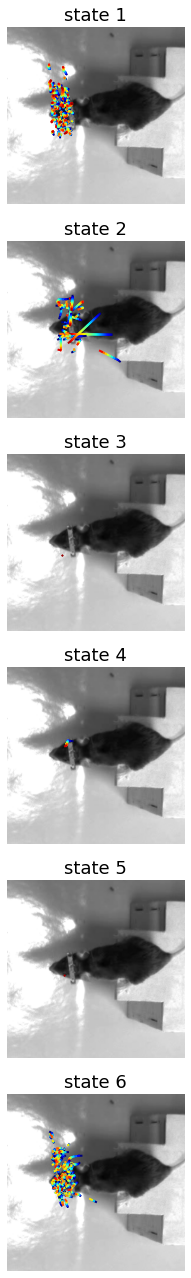

In [72]:
im_range = [450*2,600*2,325*2,175*2] #range of mouse image to plot states over
am.plot_subset_all_states(base_df,K,side,st_remap,n_rand,ts_down,time_per,st_pt,end_pt,vid_dir,im_range,False,[])


state 1 binoc vs. monoc freq p=0.928
state 2 binoc vs. monoc freq p=0.284
state 3 binoc vs. monoc freq p=0.000
state 4 binoc vs. monoc freq p=0.060
state 5 binoc vs. monoc freq p=0.005
state 6 binoc vs. monoc freq p=0.021
alpha = 0.008


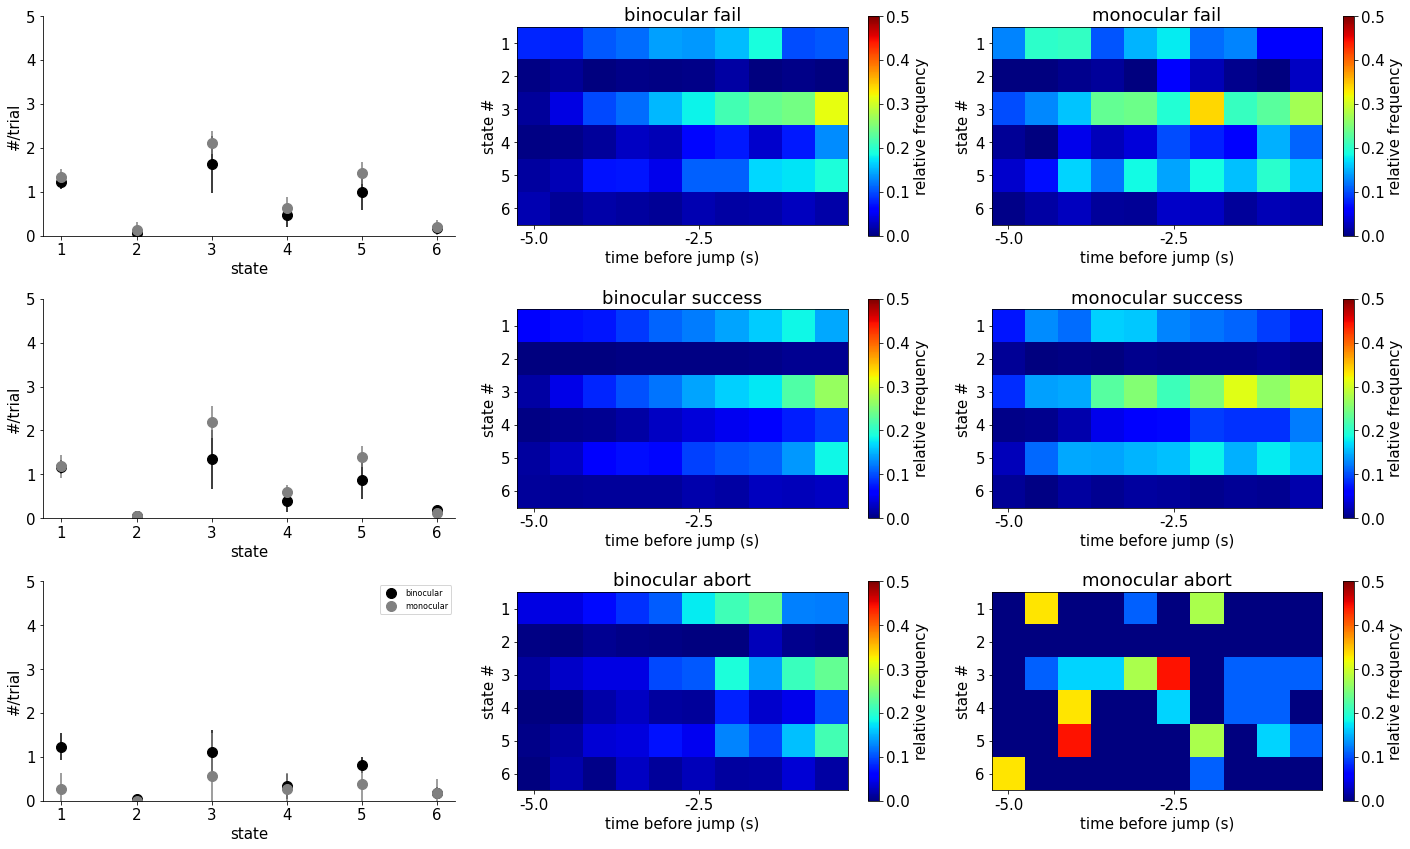

In [5]:
fig, ax, st_hist = am.plot_movement_timing_norm_tot_trials(base_df,st_remap,condition,state_key_vals,state_key_times,side,bin_min,bin_step,False,[])

In [23]:
from scipy import stats

In [26]:
for s in range(5):
    binoc = np.sum(st_hist[s,:,:,0,1],axis=0)
    monoc = np.sum(st_hist[s,:,:,1,1],axis=0)
    stat, pval = stats.ttest_rel(binoc,monoc)
    print('state %d binoc vs. monoc freq p=%0.3f' % (s+1,pval))
print('alpha = %0.3f' % (0.05/5))

state 1 binoc vs. monoc freq p=0.237
state 2 binoc vs. monoc freq p=0.004
state 3 binoc vs. monoc freq p=0.005
state 4 binoc vs. monoc freq p=0.030
state 5 binoc vs. monoc freq p=0.058
alpha = 0.010


In [18]:
s=0
st_hist[s,:,:,0].shape

(10, 8)

In [12]:
tot_hmm_freq = [len(x) for x in base_df['hmm_seq']]
base_df['tot_hmm_freq'] = tot_hmm_freq

In [10]:
base_df['hmm_1_yamp'].iloc[:5]

0    1.187534
1    0.461316
2         NaN
3    2.358720
4         NaN
Name: hmm_1_yamp, dtype: float64

(<Figure size 720x360 with 2 Axes>,
 <AxesSubplot:title={'center':'monocular'}, xlabel='gap distance (cm)', ylabel='tot_hmm_freq'>)

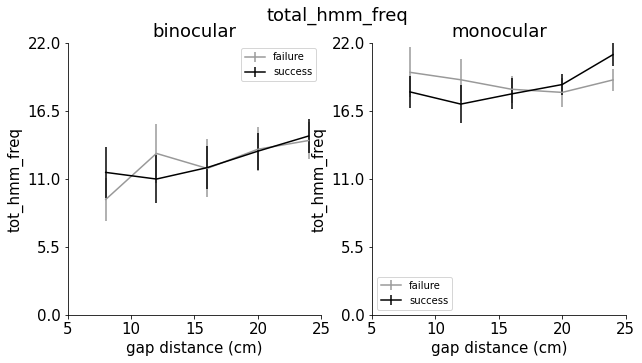

In [13]:
am.plot_variable_vs_distance(base_df,'tot_hmm_freq',condition,0,10,plot_params,False,[],suptitle='total_hmm_freq')

In [46]:
print('alpha = %0.3f' % (0.05/Krange[0]))
for hmm_k in range(Krange[0]):
    bob_freq_label = 'hmm_%d_freq' % hmm_k
    freq_max = 1
    condition = 'ocular'
    save_pdf = False
    pp=[]

    df = base_df.copy()
    anis = np.unique(df['subject'])
    dists = np.unique(df['distance'])
    conds = np.unique(df[condition])
    suc_lab = ['fail','success']
    suc_lim = [10,3]
    jet = cm.get_cmap('jet',freq_max+1)
    new_cols = jet(np.linspace(0, 1, freq_max+1))

    # fig, axs = plt.subplots(4,len(conds),figsize=(len(conds)*5,5*4))
    temp_df = am.remove_aborts(df)
    temp_df = temp_df[['subject','distance','success','jumpdist','accuracy',condition,bob_freq_label]]

    for c,cond in enumerate(conds):
    #     stats_array = np.empty((len(anis),len(dists),(freq_max + 1)))
    #     stats_array[:] = np.nan
        anova_df = pd.DataFrame(columns=['distance','freq','success'])

        for freq in np.arange(freq_max+1):

            if freq==0:
                mn = temp_df[(temp_df[bob_freq_label]==freq)&(temp_df[condition]==cond)].groupby(['distance','subject']).mean()
    #             mn.reset_index(inplace=True)
                tot_tr = len(temp_df[(temp_df[bob_freq_label]==freq)&(temp_df[condition]==cond)])
            else:
                mn = temp_df[(temp_df[bob_freq_label]>=freq)&(temp_df[condition]==cond)].groupby(['distance','subject']).mean()
    #             mn.reset_index(inplace=True)
                tot_tr = len(temp_df[(temp_df[bob_freq_label]==freq)&(temp_df[condition]==cond)])

            try:
                for d,dist in enumerate(dists):
    #                 stats_array[:,d,freq] = mn.xs(dist)['success']

                    stats_df = pd.DataFrame(columns=['distance','freq','success'])
                    stats_df['distance']  = pd.Series(np.repeat(dist,len(anis)))
                    stats_df['freq'] = pd.Series(np.repeat(freq,len(anis)))
                    stats_df['success'] = pd.Series(mn.xs(dist)['success'].to_numpy())
                    anova_df = pd.concat([anova_df,stats_df],axis=0)
            except:
                pass

        try:
            #print anova results
            model = ols('success ~ C(distance) + C(freq) + C(distance):C(freq)', data=anova_df).fit()
            anova_stats = sm.stats.anova_lm(model, typ=2)
            print(cond + ' state %s performance p=%0.3f' % (hmm_k,anova_stats['PR(>F)'].loc['C(freq)']))
    #         print(sm.stats.anova_lm(model, typ=2))
    #         print('')
        except:
            print(cond + ' state %s performance p=NaN' % (hmm_k))

        anova_df = pd.DataFrame(columns=['distance','freq','accuracy'])
        for freq in np.arange(freq_max+1):
            if freq==0:
                mn = temp_df[(temp_df[bob_freq_label]==freq)&(temp_df[condition]==cond)].groupby(['distance','subject']).mean()
                tot_tr = len(temp_df[(temp_df[bob_freq_label]==freq)&(temp_df[condition]==cond)])
            else:
                mn = temp_df[(temp_df[bob_freq_label]>=freq)&(temp_df[condition]==cond)].groupby(['distance','subject']).mean()
                tot_tr = len(temp_df[(temp_df[bob_freq_label]>=freq)&(temp_df[condition]==cond)])

            try:
                for d,dist in enumerate(dists):
            #                 stats_array[:,d,freq] = mn.xs(dist)['success']

                    stats_df = pd.DataFrame(columns=['distance','freq','accuracy'])
                    stats_df['distance']  = pd.Series(np.repeat(dist,len(anis)))
                    stats_df['freq'] = pd.Series(np.repeat(freq,len(anis)))
                    stats_df['accuracy'] = pd.Series(mn.xs(dist)['accuracy'].to_numpy())
                    anova_df = pd.concat([anova_df,stats_df],axis=0)
            except:
                pass
        
        try:
            #print anova results
            model = ols('accuracy ~ C(distance) + C(freq) + C(distance):C(freq)', data=anova_df).fit()
            anova_stats = sm.stats.anova_lm(model, typ=2)
            print(cond + ' state %s accuracy p=%0.3f' % (hmm_k,anova_stats['PR(>F)'].loc['C(freq)']))
        except:
            print(cond + ' state %s accuracy p=NaN' % (hmm_k))
    print(' ')
#         print(cond + ' accuracy')
#         print(sm.stats.anova_lm(model, typ=2))
#         print('')

alpha = 0.003
binocular state 0 performance p=0.522
binocular state 0 accuracy p=0.204
monocular state 0 performance p=0.804
monocular state 0 accuracy p=0.434
 
binocular state 1 performance p=0.469
binocular state 1 accuracy p=0.512
monocular state 1 performance p=0.683
monocular state 1 accuracy p=0.307
 
binocular state 2 performance p=0.826
binocular state 2 accuracy p=0.867
monocular state 2 performance p=0.949
monocular state 2 accuracy p=0.864
 
binocular state 3 performance p=0.914
binocular state 3 accuracy p=0.899
monocular state 3 performance p=0.526
monocular state 3 accuracy p=0.551
 
binocular state 4 performance p=0.513
binocular state 4 accuracy p=0.804
monocular state 4 performance p=0.011
monocular state 4 accuracy p=0.263
 
binocular state 5 performance p=0.948
binocular state 5 accuracy p=0.499
monocular state 5 performance p=0.238
monocular state 5 accuracy p=0.972
 
binocular state 6 performance p=0.587
binocular state 6 accuracy p=0.517
monocular state 6 perform

In [37]:
5.75e-2

0.0575

In [38]:
0.05/8

0.00625

In [6]:
anova_stats = sm.stats.anova_lm(model, typ=2)

anova_stats['PR(>F)'].loc['C(freq)']

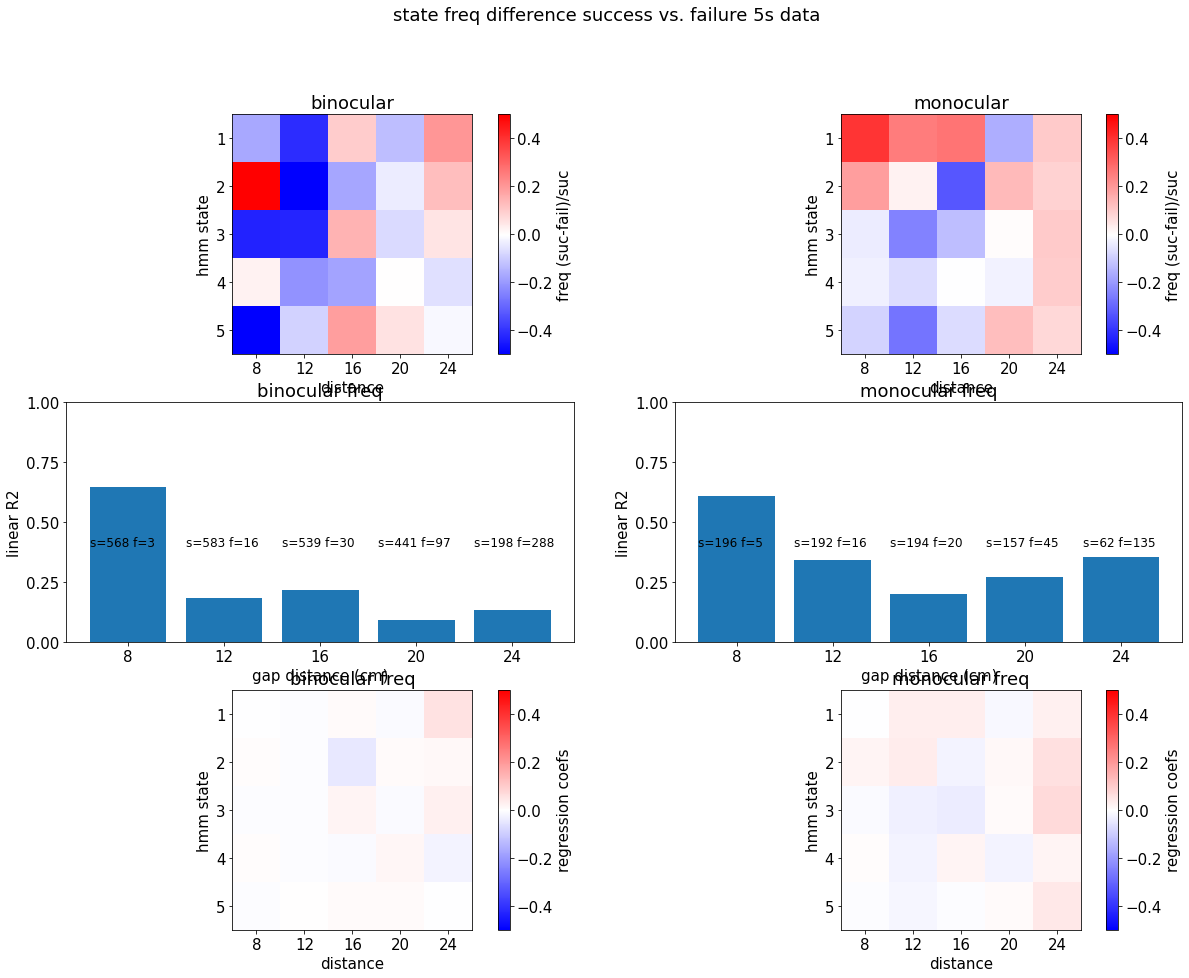

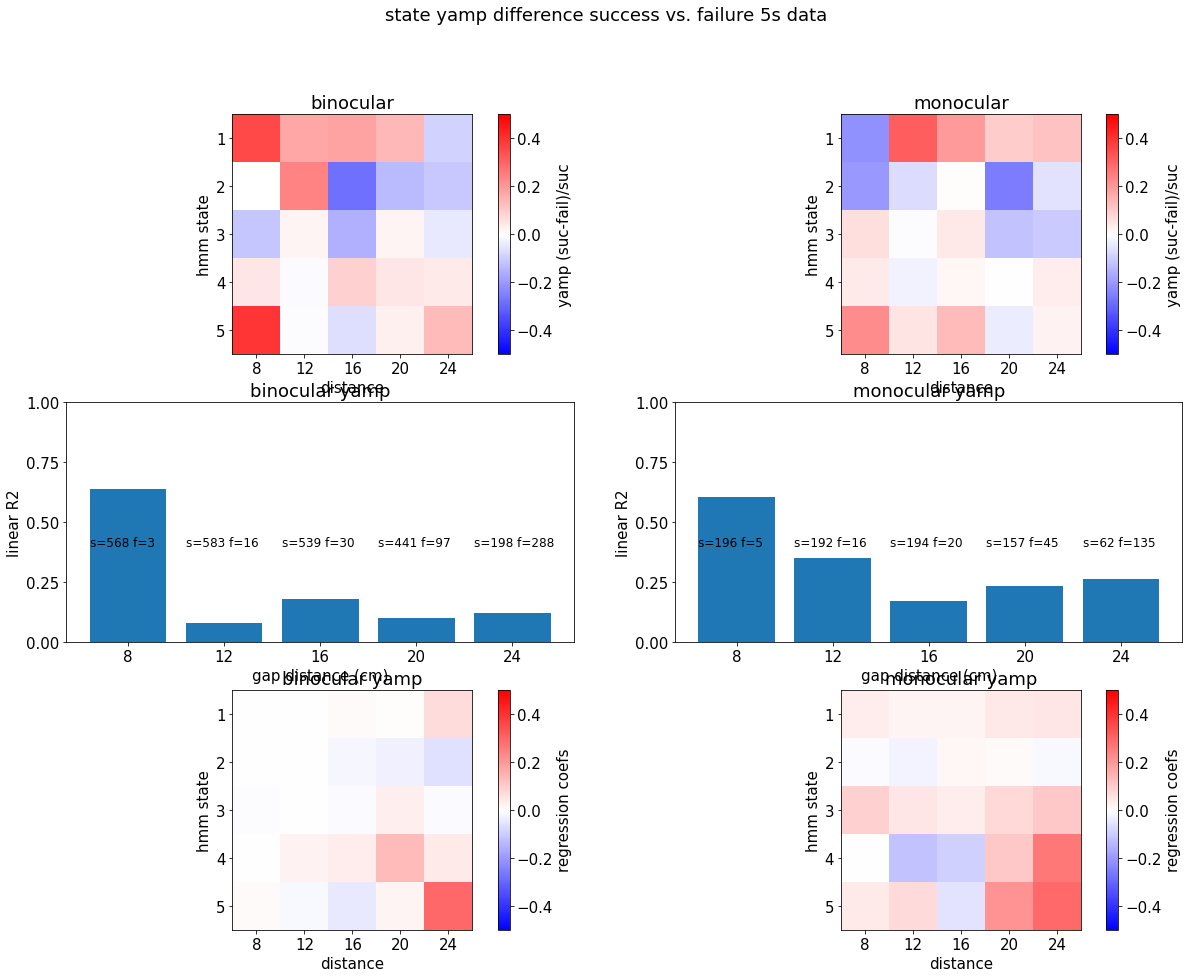

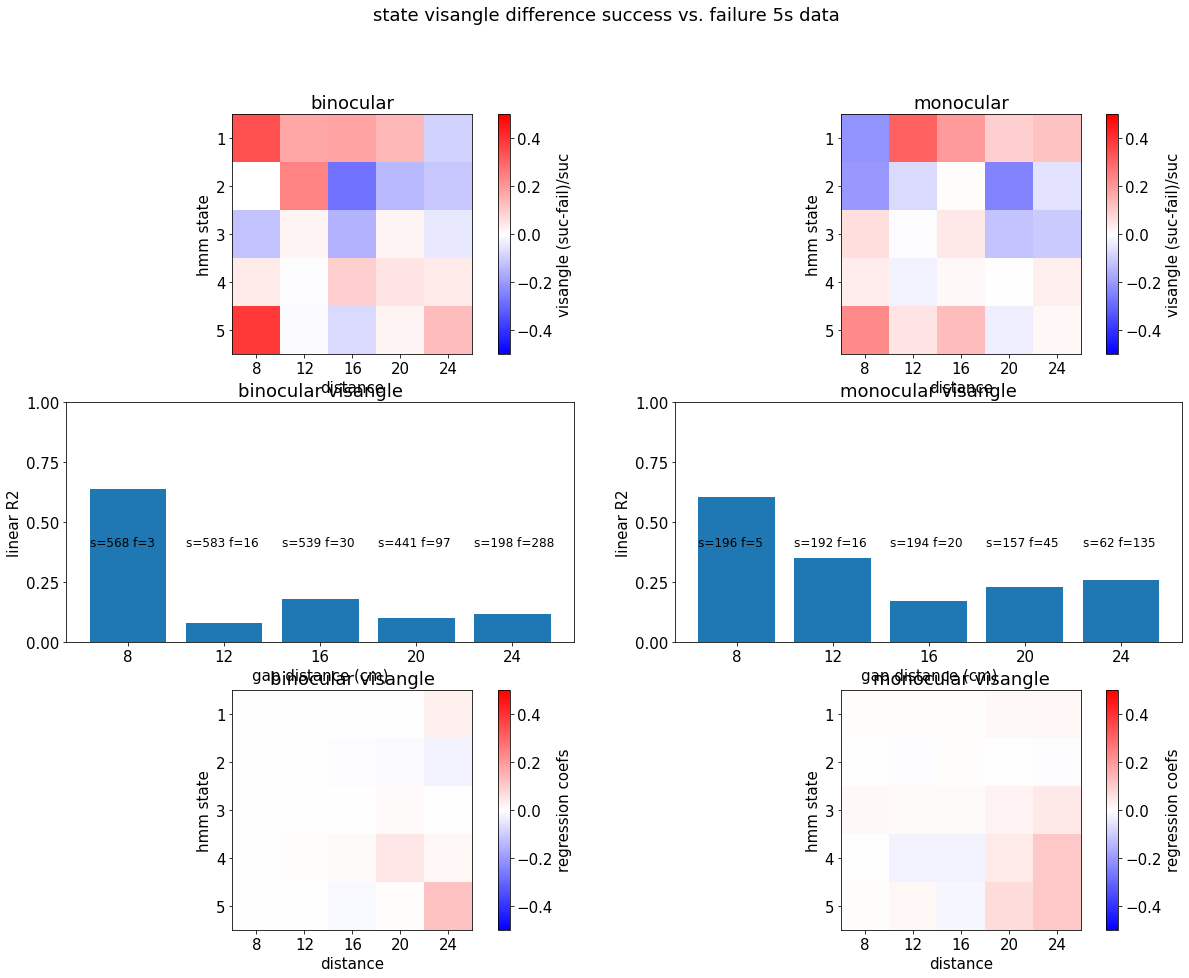

In [53]:
plt_lims = [0.5,0.5,0.5]
plt_types = ['freq','yamp','visangle']
fig, ax, grp_heat = am.plot_state_freq_difference(base_df,st_remap,plt_types,plt_lims,time_per,condition,False,[])

In [55]:
oc = ['binocular','monocular']
for pl,plt_type in enumerate(plt_types):
    for c,cond in enumerate(conds):
        for st in range(len(st_remap)):
            for d,dist in enumerate(dists):
                fail = grp_heat[:,st,d,0,c,pl]
                suc = grp_heat[:,st,d,1,c,pl]
                fail = fail[~np.isnan(fail)]
                suc = suc[~np.isnan(suc)]

                s, p = stats.ttest_ind(fail,suc)
#                 print(fail,suc)
                print('%s %s state %d, distance %d, p=%0.5f' % (plt_type,cond,(st+1),dist,p))

freq control state 1, distance 8, p=0.68483
freq control state 1, distance 12, p=0.51591
freq control state 1, distance 16, p=0.71928
freq control state 1, distance 20, p=0.78544
freq control state 1, distance 24, p=0.07181
freq control state 2, distance 8, p=0.07801
freq control state 2, distance 12, p=0.37369
freq control state 2, distance 16, p=0.39636
freq control state 2, distance 20, p=0.85607
freq control state 2, distance 24, p=0.33603
freq control state 3, distance 8, p=0.78942
freq control state 3, distance 12, p=0.47030
freq control state 3, distance 16, p=0.90423
freq control state 3, distance 20, p=0.71024
freq control state 3, distance 24, p=0.71893
freq control state 4, distance 8, p=0.28537
freq control state 4, distance 12, p=0.82297
freq control state 4, distance 16, p=0.76083
freq control state 4, distance 20, p=0.99464
freq control state 4, distance 24, p=0.70117
freq control state 5, distance 8, p=0.59927
freq control state 5, distance 12, p=0.61029
freq control st

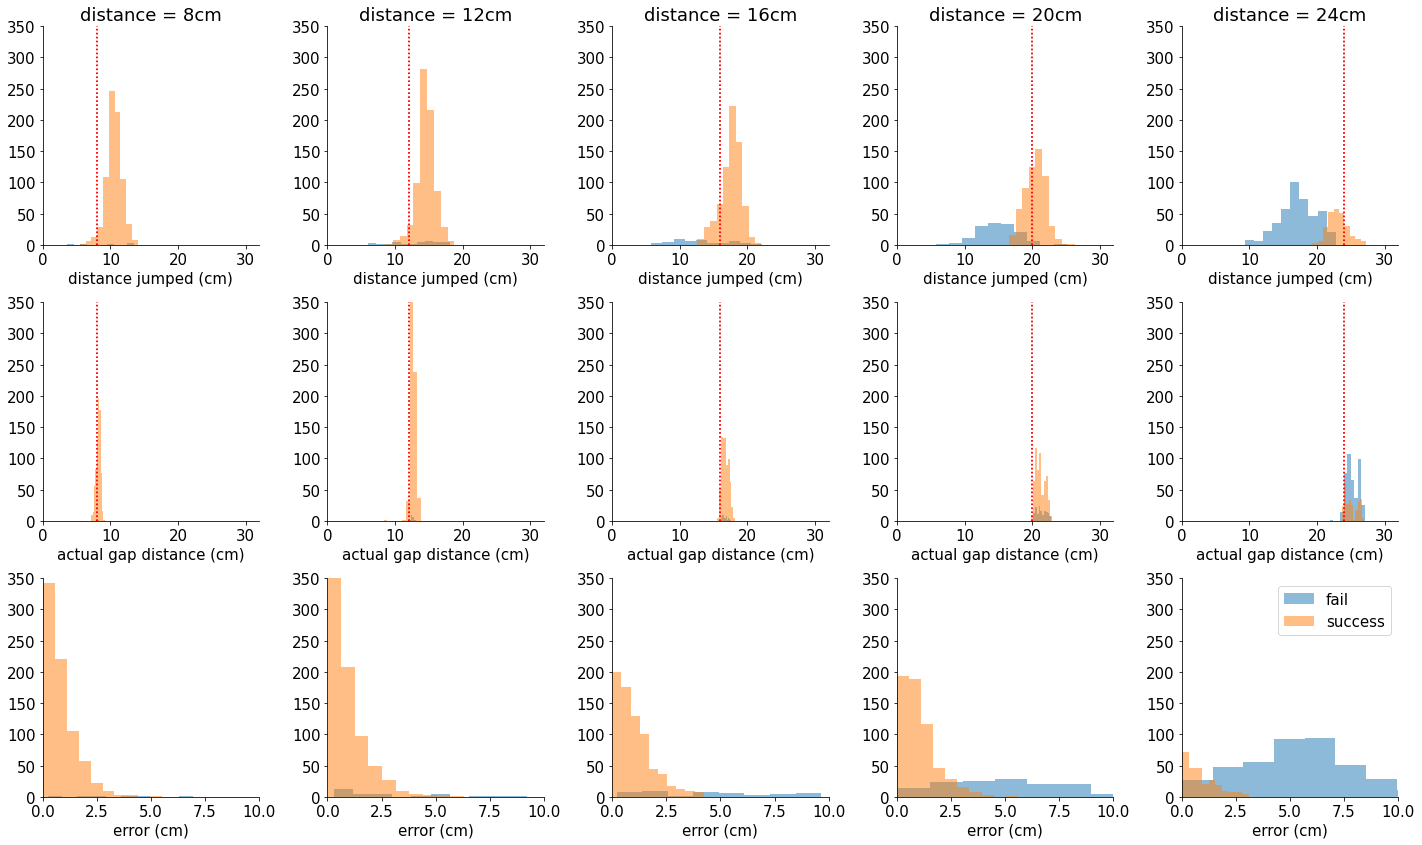

In [29]:
fig, axs = plt.subplots(3,len(dists),figsize=(4*len(dists),4*3))
# axs = axs.ravel()
suc_label = ['fail','success']
suc_df = base_df[(base_df['success']==1)]
suc_df.reset_index(inplace=True)
fail_df = base_df[(base_df['success']==0)]
fail_df.reset_index(inplace=True)
dfs = [fail_df,suc_df]
for df_n,df in enumerate(dfs):
    for d,dist in enumerate(dists):
        ax = axs[0,d]
        ax.hist(df[df['distance']==dist]['jumpdist'],alpha=0.5,label=suc_label[df_n])
        ax.plot([dist,dist],[0,350],'r:')
        ax.set_xlim(0,32)
        ax.set_ylim(0,350)
        ax.set_title('distance = %dcm' % dist)
        ax.set_xlabel('distance jumped (cm)')
        ax = am.xy_axis(ax)

        ax = axs[1,d]
        ax.hist(df[df['distance']==dist]['actual_distance'],alpha=0.5,label=suc_label[df_n])
        ax.plot([dist,dist],[0,350],'r:')
        ax.set_xlim(0,32)
        ax.set_ylim(0,350)
        ax.set_xlabel('actual gap distance (cm)')
        ax = am.xy_axis(ax)

        ax = axs[2,d]
        ax.hist(df[df['distance']==dist]['accuracy'],alpha=0.5,label=suc_label[df_n])
        ax.set_xlim(0,10)
        ax.set_ylim(0,350)
        ax.set_xlabel('error (cm)')
        ax = am.xy_axis(ax)
ax.legend()
fig.tight_layout()

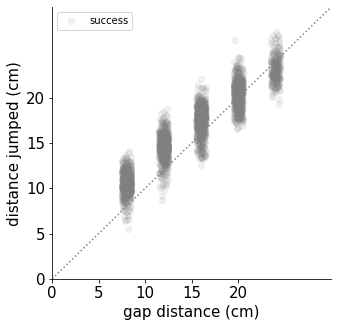

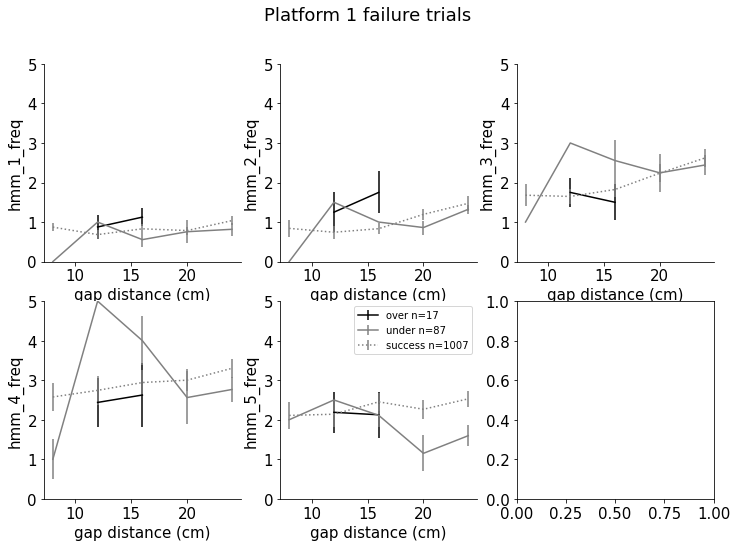

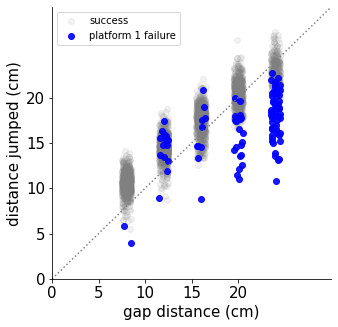

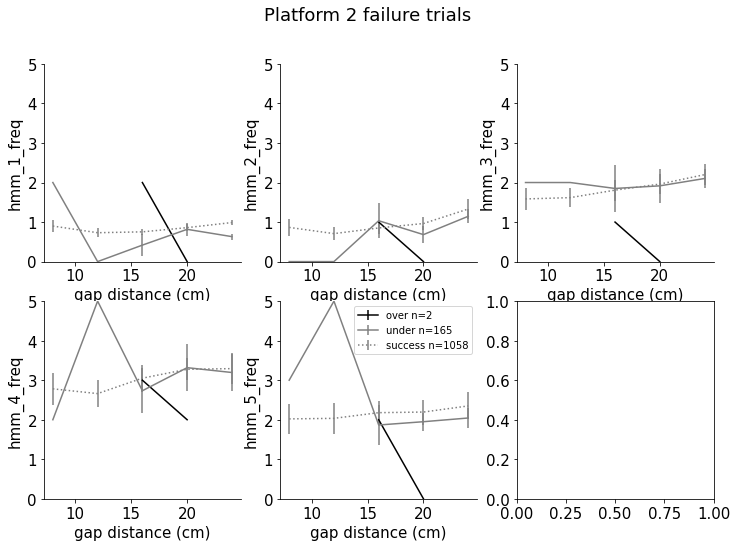

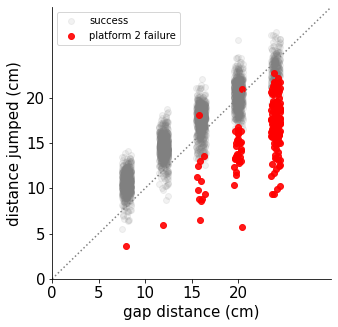

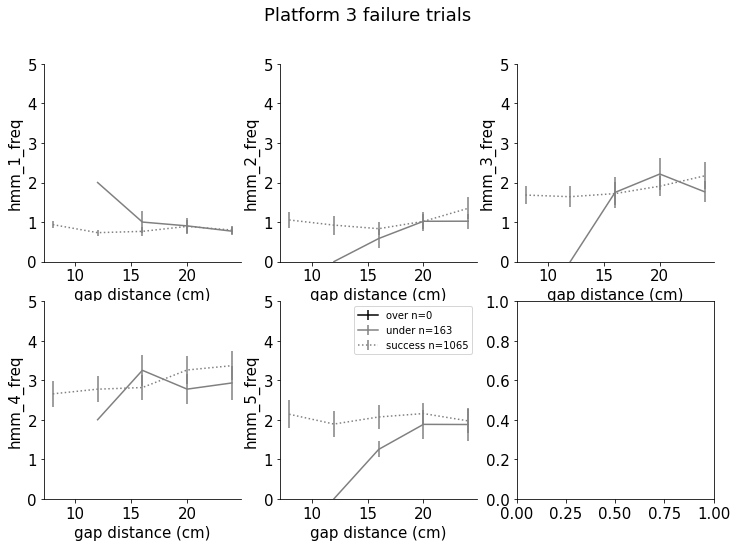

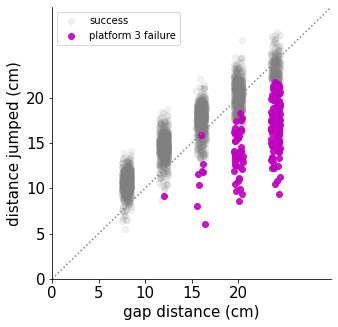

In [27]:
### Plot over/under failure statistics

jd_fig, jd_ax = plt.subplots(1,1,figsize=(5,5))
suc_df = base_df[(base_df['success']==1)]
suc_df.reset_index(inplace=True)
jd_ax.plot(suc_df['distance']+np.random.random(suc_df.shape[0])-0.5,suc_df['jumpdist'],
               'o',color=[0.5,0.5,0.5],alpha=0.1,label='success')
jd_ax.set_xlim(0,30)
jd_ax.set_ylim(0,30)
jd_ax.set_xticks(np.arange(0,25,5))
jd_ax.set_yticks(np.arange(0,25,5))
jd_ax.set_xlabel('gap distance (cm)')
jd_ax.set_ylabel('distance jumped (cm)')
jd_ax.plot([0,30],[0,30],':',color=[0.5,0.5,0.5])
jd_ax.legend(fontsize=10)
jd_ax = am.xy_axis(jd_ax)

for p,plat_num in enumerate(np.arange(1,4)):
    p1over = base_df[(base_df['success']==0)&(base_df['platform']==plat_num)&(base_df['jumpdist']>base_df['distance'])&(base_df['ocular']=='binocular')]
    p1over.reset_index(inplace=True)
    p1under = base_df[(base_df['success']==0)&(base_df['platform']==plat_num)&(base_df['jumpdist']<base_df['distance'])&(base_df['ocular']=='binocular')]
    p1under.reset_index(inplace=True)
    p1suc = base_df[(base_df['success']==1)&(base_df['platform']==plat_num)]
    p1suc.reset_index(inplace=True)
    
#     under_sub = []
#     for idx,row in p1under.iterrows():
#         under_sub.append((row['Side TakeFL x'][-1] - row['Side LEye x'][-1])/row['Side_pixpercm'])
#     over_sub = []
#     for idx,row in p1over.iterrows():
#         over_sub.append((row['Side TakeFL x'][-1] - row['Side LEye x'][-1])/row['Side_pixpercm'])

    anis = np.unique(p1over['subject'])
    p1over_jumpcurve = p1over.groupby(['distance','subject']).mean()
    p1over_mn = p1over_jumpcurve.groupby(['distance']).mean()
    p1over_sem = p1over_jumpcurve.groupby(['distance']).std()/np.sqrt(len(anis))
    p1over_mn.reset_index(inplace=True)
    p1over_sem.reset_index(inplace=True)

    anis = np.unique(p1under['subject'])
    p1under_jumpcurve = p1under.groupby(['distance','subject']).mean()
    p1under_mn = p1under_jumpcurve.groupby(['distance']).mean()
    p1under_sem = p1under_jumpcurve.groupby(['distance']).std()/np.sqrt(len(anis))
    p1under_mn.reset_index(inplace=True)
    p1under_sem.reset_index(inplace=True)
    
    anis = np.unique(p1suc['subject'])
    p1suc_jumpcurve = p1suc.groupby(['distance','subject']).mean()
    p1suc_mn = p1suc_jumpcurve.groupby(['distance']).mean()
    p1suc_sem = p1suc_jumpcurve.groupby(['distance']).std()/np.sqrt(len(anis))
    p1suc_mn.reset_index(inplace=True)
    p1suc_sem.reset_index(inplace=True)

    over_n = p1over.shape[0]
    under_n = p1under.shape[0]
    suc_n = p1suc.shape[0]

    variable = 'hmm_%d_freq'
    fig, axs = plt.subplots(2,int(np.ceil(len(st_remap)/2)),figsize=(int(np.ceil(len(st_remap)/2))*4,8))
    axs = axs.ravel()
    for s,st in enumerate(st_remap):
        ax = axs[s]
        ax.errorbar(x=p1over_mn['distance'],y=p1over_mn[variable % st],yerr=p1over_sem[variable % st],color='k',label='over n=%d' % over_n)
        ax.errorbar(x=p1under_mn['distance'],y=p1under_mn[variable % st],yerr=p1under_sem[variable % st],color=[0.5,0.5,0.5],label='under n=%d' % under_n)
        ax.errorbar(x=p1suc_mn['distance'],y=p1suc_mn[variable % st],yerr=p1suc_sem[variable % st],color=[0.5,0.5,0.5],linestyle=':',label='success n=%d' % suc_n)
        ax.set_xlabel('gap distance (cm)')
        ax.set_ylabel(variable % (s+1))
        ax.set_ylim(0,5)
        ax = am.xy_axis(ax)
    ax.legend(fontsize=10)
    fig.suptitle('Platform %d failure trials' % plat_num)

    jd_fig, jd_ax = plt.subplots(1,1,figsize=(5,5))
    suc_df = base_df[(base_df['success']==1)]
    suc_df.reset_index(inplace=True)
    jd_ax.plot(suc_df['distance']+np.random.random(suc_df.shape[0])-0.5,suc_df['jumpdist'],
                   'o',color=[0.5,0.5,0.5],alpha=0.1,label='success')
    jd_ax.plot(p1over['distance']+np.random.random(p1over.shape[0])-0.5,p1over['jumpdist'],
               'o',color=plot_params['plat_cols'][p],alpha=0.9)
    jd_ax.plot(p1under['distance']+np.random.random(p1under.shape[0])-0.5,p1under['jumpdist'],
               'o',color=plot_params['plat_cols'][p],alpha=0.9,label='platform %d failure' % plat_num)
    
    jd_ax.set_xlim(0,30)
    jd_ax.set_ylim(0,30)
    jd_ax.set_xticks(np.arange(0,25,5))
    jd_ax.set_yticks(np.arange(0,25,5))
    jd_ax.set_xlabel('gap distance (cm)')
    jd_ax.set_ylabel('distance jumped (cm)')
    jd_ax.plot([0,30],[0,30],':',color=[0.5,0.5,0.5])
    jd_ax.legend(fontsize=10)
    jd_ax = am.xy_axis(jd_ax)


In [304]:
temp_df['accuracy']

0       0.082193
1       1.153792
2       8.069269
3       4.899869
4       0.478986
          ...   
3780    1.185093
3781    0.628187
3782    4.348675
3783    0.766252
3784    0.184596
Name: accuracy, Length: 3785, dtype: float64

Text(0.5, 0, 'gap distance (cm)')

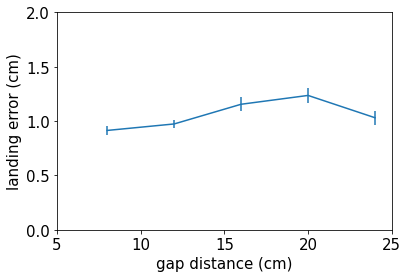

In [5]:
temp_df = base_df[base_df['success']==1]
jumpcurve = temp_df.groupby(['distance','subject']).mean()
mnplot = jumpcurve.groupby('distance').mean()
mnplot.reset_index(inplace=True)
semplot = jumpcurve.groupby('distance').std()/np.sqrt(len(np.unique(temp_df['subject'])))
semplot.reset_index(inplace=True)
plt.errorbar(mnplot['distance'],mnplot['accuracy'],yerr=semplot['accuracy'])
plt.ylim(0,2)
plt.xlim(5,25)
plt.ylabel('landing error (cm)')
plt.xlabel('gap distance (cm)')

In [25]:
pdf_file = r'C:\Users\nlab\Google Drive\Niell\Jumping paper\Manuscript\Figures\raw panels\Figure2Btop.pdf'
pp = PdfPages(pdf_file)
fig, ax = am.plot_performance(base_df,condition,1,7,27,plot_params,True,pp)
pp.close()

monocular
                            sum_sq    df           F        PR(>F)
C(distance)               4.428328   4.0  128.943497  1.623845e-31
C(condition)              0.001099   1.0    0.128029  7.215610e-01
C(distance):C(condition)  0.010485   4.0    0.305292  8.735032e-01
Residual                  0.601005  70.0         NaN           NaN

distance 8, p=0.618
distance 12, p=0.055
distance 16, p=0.934
distance 20, p=0.608
distance 24, p=0.820
alpha=0.010


In [23]:
pdf_file = r'C:\Users\nlab\Google Drive\Niell\Jumping paper\Manuscript\Figures\raw panels\Figure2Bbottom.pdf'
pp = PdfPages(pdf_file)
fig, ax = am.plot_jumpdist(base_df,condition,7,27,plot_params,True,pp,suptitle='')
pp.close()

monocular
                               sum_sq    df            F        PR(>F)
C(distance)               1649.921847   4.0  1227.192080  5.364008e-64
C(condition)                 0.151698   1.0     0.451323  5.039184e-01
C(distance):C(condition)     0.274449   4.0     0.204132  9.352967e-01
Residual                    23.528209  70.0          NaN           NaN

distance 8, p=0.549
distance 12, p=0.706
distance 16, p=0.083
distance 20, p=0.829
distance 24, p=0.518
alpha=0.010


In [24]:
pdf_file = r'C:\Users\nlab\Google Drive\Niell\Jumping paper\Manuscript\Figures\raw panels\Figure2Ctop.pdf'
pp = PdfPages(pdf_file)
fig, ax = am.plot_performance_platforms(base_df,condition,1,7,27,plot_params,True,pp)
pp.close()

Loading BokehJS ...

binocular
                           sum_sq     df          F        PR(>F)
C(distance)              6.489396    4.0  99.121311  9.491873e-35
C(platform)              0.051005    2.0   1.558151  2.153530e-01
C(distance):C(platform)  0.107669    8.0   0.822289  5.847125e-01
Residual                 1.718567  105.0        NaN           NaN

monocular
                           sum_sq     df          F        PR(>F)
C(distance)              6.306508    4.0  78.941430  9.050846e-31
C(platform)              0.000156    2.0   0.003897  9.961112e-01
C(distance):C(platform)  0.502724    8.0   3.146412  3.126648e-03
Residual                 2.097072  105.0        NaN           NaN



In [21]:
pdf_file = r'C:\Users\nlab\Google Drive\Niell\Jumping paper\Manuscript\Figures\raw panels\Figure2Cbottom.pdf'
pp = PdfPages(pdf_file)
fig, ax = am.plot_jumpdist_platforms(base_df,condition,7,27,plot_params,True,pp)
pp.close()

binocular
                               sum_sq     df         F    PR(>F)
C(distance)              1.607891e-30    4.0  0.972798  0.425714
C(platform)              5.657598e-30    2.0  6.845865  0.001605
C(distance):C(platform)  3.241743e-30    8.0  0.980652  0.455334
Residual                 4.338735e-29  105.0       NaN       NaN

monocular
                               sum_sq     df          F        PR(>F)
C(distance)              3.031308e-28    4.0  12.200755  3.826930e-08
C(platform)              4.499647e-31    2.0   0.036221  9.644392e-01
C(distance):C(platform)  7.980877e-30    8.0   0.160612  9.953817e-01
Residual                 6.335539e-28  102.0        NaN           NaN



Loading BokehJS ...

could not do anova due to nans
distance 8, p=nan
distance 12, p=0.147
distance 16, p=nan
distance 20, p=0.907
distance 24, p=0.038
alpha=0.010
could not do anova due to nans
distance 8, p=nan
distance 12, p=nan
distance 16, p=0.017
distance 20, p=0.145
distance 24, p=0.025
alpha=0.010


(<Figure size 720x360 with 2 Axes>,
 <AxesSubplot:title={'center':'monocular'}, xlabel='gap distance (cm)', ylabel='trial_dur'>)

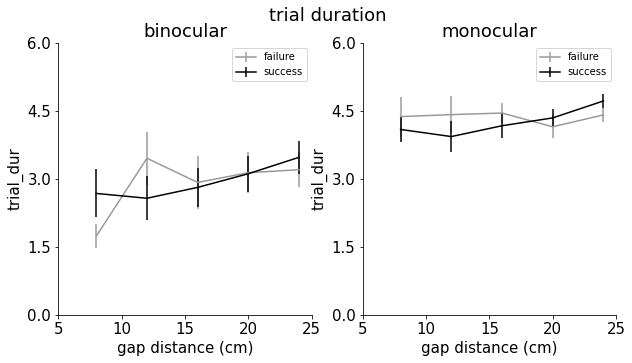

In [167]:
### there are some distances without failures or successes...

am.plot_variable_vs_distance(base_df,'trial_dur',condition,0,20,plot_params,False,[],suptitle='trial duration')

In [150]:
stats_array = np.empty((len(anis),len(dists),len(conds)))
stats_array[:] = np.nan

anova_df = pd.DataFrame(columns=['distance','condition','success'])


for d,dist in enumerate(dists):
    stats_array[:,d,c] = jumpcurve.xs(dist)['success']

    temp_df = pd.DataFrame(columns=['distance','condition','success'])
    temp_df['distance']  = pd.Series(np.repeat(dist,len(anis)))
    temp_df['condition'] = pd.Series(np.repeat(cond,len(anis)))
    temp_df['success'] = pd.Series(jumpcurve.xs(dist)['success'].to_numpy())
    anova_df = pd.concat([anova_df,temp_df],axis=0)
    
    
#print anova results
model = ols('success ~ C(distance) + C(condition) + C(distance):C(condition)', data=anova_df).fit()
print(cond)
print(sm.stats.anova_lm(model, typ=2))
print('')

for d,dist in enumerate(dists):
    s, p = stats.ttest_rel(stats_array[:,d,0],stats_array[:,d,1])
    print('distance %d, p=%0.3f' % (dist,p))
print('alpha=%0.3f' % (0.05/len(dists)))

monocular


ValueError: must have at least one row in constraint matrix

distance 8, p=0.597
distance 12, p=0.040
distance 16, p=0.935
distance 20, p=0.684
distance 24, p=0.861
alpha=0.010


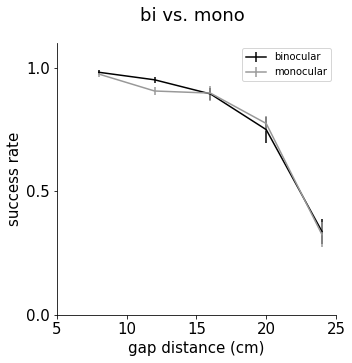

In [40]:
condition = 'ocular'
plt_min = 5
plt_max = 25
suptitle = 'bi vs. mono'
og_df = base_df.copy()
aborts=1
if aborts:
    df = am.aborts_as_failures(og_df)
else: 
    df = am.remove_aborts(og_df)
# df = aborts_as_failures(og_df)
anis = np.unique(df['subject'])
dists = np.unique(df['distance'])
conds = np.unique(df[condition])

stats_array = np.empty((len(anis),len(dists),len(conds)))

fig, ax = plt.subplots(1,1,figsize=(5,5))
for c,cond in enumerate(conds):
    jumpcurve = df[df[condition]==cond].groupby(['distance','subject']).mean()
#     jumpcurve.reset_index(inplace=True)
    mnplot = jumpcurve.groupby(['distance']).mean()
    semplot = jumpcurve.groupby(['distance']).std()/np.sqrt(len(anis))
    mnplot.reset_index(inplace=True)
    semplot.reset_index(inplace=True)

    plt.errorbar(mnplot['distance'],
             mnplot['success'],
             yerr=semplot['success'],label=cond,color=plot_params['cond_col'][c])
    
    for d,dist in enumerate(dists):
        stats_array[:,d,c] = jumpcurve.xs(dist)['success']

ax.set_xlabel('gap distance (cm)')
ax.set_ylabel('success rate')
ax.set_xlim(plt_min,plt_max)
# ax.set_xticks(np.arange(plt_min,plt_min,plt_max+plt_min))
ax.set_ylim(0,1.1)
ax.set_yticks(np.arange(0, 1.5, step=0.5))
ax.legend(fontsize=10)
ax = am.xy_axis(ax)
# if len(anis)==1:
#     fig.suptitle(anis[0])
fig.suptitle(suptitle)

for d,dist in enumerate(dists):
    s, p = stats.ttest_ind(stats_array[:,d,0],stats_array[:,d,1])
    print('distance %d, p=%0.3f' % (dist,p))
print('alpha=%0.3f' % (0.05/len(dists)))

In [6]:
### plot decision period for individual trials with likelihood

idx = 0

xtr = base_df['Side LEye x'].iloc[idx][st_pt:end_pt]
ytr = base_df['Side LEye y'].iloc[idx][st_pt:end_pt]
like = base_df['Side LEye likelihood'].iloc[idx][st_pt:end_pt]
sup = '%s %s %s' % (base_df['expdate'].iloc[idx],base_df['subject'].iloc[idx],base_df['trial'].iloc[idx])

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5))
ax1.plot(xtr,ytr)
ax1.set_title('xy trace')
ax1.set_xlabel('x pixel')
ax1.set_ylabel('y pixel')
ax1 = am.xy_axis(ax1)

ax2.plot(xtr,label='x eye')
ax2.plot(ytr,label='y eye')
ax2.set_title('individual x/y')
ax2.set_xlabel('frame #')
ax2.set_ylabel('pixel')
ax2.legend(fontsize=10)
ax2 = am.xy_axis(ax2)

ax3.plot(like)
ax3.set_title('DLC likelihood')
ax3.set_ylim(0,1.05)
ax3.set_xlabel('frame #')
ax3.set_ylabel('likelihood')
ax3 = am.xy_axis(ax3)

fig.suptitle(sup)

KeyError: 'Side LEye x'

In [2]:
# ###### pick a folder below (KDir) and loop through all the values of K run with that model
# top_dir = r'\\sendak\D\Phil\jumping_analysis\paper_cohort\ARHMM\*'
# vid_dir = r'\\sendak\D\Phil\jumping_analysis\paper_cohort\clipped_vids'
# pdf_dir = r'\\sendak\D\Phil\jumping_analysis\paper_cohort\ARHMMpdfs'
# models = glob(top_dir)
# Krange = np.arange(6,17) # the range of values used for K in the analysis (6,17 default)
# conditions = ['control','suture']
# Performance = 1
# ts_down = 2

# cond_lab = 'ocular'
# state_key_vals = 'hmm_seq'
# state_key_times = 'hmm_times'
# side = 'Side'
# bin_min = -5
# bin_step = 0.25

# # for m_num,model in enumerate(models):
# #     for Kind,K in enumerate(Krange):
# m_num=0
# model = r'D:\Phil\jumping_analysis\paper_cohort\ARHMM\sticky-ARHMM_lag-1_dsf-2_kappa-1e+04_2020-11-16_0150'
# Kind = 0
# K = 12
# KDir = os.path.join(model,'K-%s' % str(K).zfill(2))
# fpath = glob(os.path.join(KDir,'MAP_seqs*.h5'))[0]
# trMAPs, trPosteriors, trMasks, arhmm_params, opt = ioh5.load_MAP_seqs_h5(fpath)

# trMasks2 = []
# tBins_removed = []
# for iTrial, mapseq in enumerate(trMAPs):
#     #Apply posterior probability threshold mask
#     MAPcp = mapseq.copy()
#     mask = trMasks[iTrial]
#     MAPcp[~mask] = -1
#     #Loop over states and NaN out that were less than 100ms (3 frames)
#     for state in range(K):
#         state_1hot = np.concatenate(([0],(np.array(MAPcp) == state).astype(int),[0]))
#         state_trans = np.diff(state_1hot)
#         state_ends = np.nonzero(state_trans == -1)[0]
#         state_starts = np.nonzero(state_trans == +1)[0]
#         state_durations = state_ends - state_starts
#         #State was not used this trial
#         if len(state_durations) == 0:
#             continue
#         #Loop over the individual state sequences and NaN out the short ones
#         for iSeq, sd in enumerate(state_durations):
#             if sd <= 3: #3 frames, so 90ms for 2x downsampled data
#                 MAPcp[slice(state_starts[iSeq],state_ends[iSeq])] = -1
#     #Update mask
#     mask2 = MAPcp != -1
#     trMasks2.append(mask2)
#     #See how much of a difference that made
#     tBins_removed.append(np.sum(mask)-np.sum(mask2))


# n_k = 12 # number of clusters in the dataset
# df_file = r'\\sendak\C\Users\nlab\Box Sync\Phil Niell Lab\Behavior\Jumping task\analysis\paper_cohort_alldata_500msClusts_df_%dclusts.h5' % n_k
# labels_file = r'\\sendak\C\Users\nlab\Box Sync\Phil Niell Lab\Behavior\Jumping task\analysis\paper_cohort_alldata_500msClusts_labels_%dclusts.h5' % n_k
# df_all = pd.read_hdf(df_file)
# labels_all = pd.read_hdf(labels_file)
# df_all['trMAPs'] = trMAPs
# df_all['trPosteriors'] = trPosteriors
# df_all['trMasks'] = trMasks2 # note which version of masking you want

# ### add the hmm sequences and their start frames to the df
# hmm_seq,hmm_ind = ([] for i in range(2))
# for maps,masks in zip(trMAPs,trMasks2):
#     st_lab = maps.copy()
#     st_lab[~masks] = -1
#     n_seq,goods,inds = am.get_arhmm_start_frames(st_lab)
#     hmm_seq.append(goods)#[~bads])
#     hmm_ind.append(inds)#[~bads])
# df_all['hmm_seq'] = hmm_seq
# df_all['hmm_ind'] = hmm_ind

# ### calculate the trial durations and the times of the hmm state starts
# trial_dur,hmm_times = ([] for i in range(2))
# for index,row in df_all.iterrows():
#     xtr,ytr = am.filter_decision_period(row,'Side','LEye',0.95,ts_down)
#     td = len(xtr)
#     trial_dur.append(td/(row['fps']/ts_down))
#     hmm_times.append((row['hmm_ind']-td)/(row['fps']/ts_down))
# df_all['hmm_times'] = hmm_times
# df_all['trial_dur'] = trial_dur

# ### baseline (no opto) data
# base_df = df_all.copy()
# base_df = base_df[base_df['laser_trial']=='laser off']
# base_df.reset_index(inplace=True,drop=True)
# base_df[base_df['condition']=='opto suture'] = base_df[base_df['condition']=='opto suture'].replace('opto suture','suture')
# base_df = am.get_jump_accuracy(base_df)

# base_labels = labels_all.copy()
# base_labels = base_labels[base_labels['laser_trial']=='laser off']
# base_labels.reset_index(inplace=True,drop=True)
# base_labels[base_labels['condition']=='opto suture'] = base_labels[base_labels['condition']=='opto suture'].replace('opto suture','suture')
# base_labels = am.get_movement_amplitudes_mm(base_labels,'Side')

# print('finished loading data!')

finished loading data!


# Create cropped videos showing single state in jet-colored time sequence

In [5]:
def find(pattern, path):

	### a function that returns the full file path in a list given a pattern and directory, includes subfolders
    
    result = []
    for root, dirs, files in os.walk(path):
        for name in files: 
            if fnmatch.fnmatch(name,pattern): 
                result.append(os.path.join(root,name))
    return result

def make_path(base,row):
    if row['success']==1:
        suc = 'success'
    else:
        suc = 'fail'
    
    pathname = os.path.join(base,row['subject'] + '\\' + suc)
    
    if not os.path.exists(pathname):
        os.makedirs(pathname)
        
    return pathname

# Draw points on frame
def draw_points(frame, x, y, color,ptsize):
    point_adds = product(range(-ptsize,ptsize), range(-ptsize,ptsize))
    for pt in point_adds:
        try:
            frame[x+pt[0],y+pt[1]] = color
        except IndexError:
            pass
    return frame

# # Draw points on frame
# def draw_points(frame, x, y, color,ptsize):
#     point_adds = product(range(-ptsize,ptsize), range(-ptsize,ptsize))
#     for pt in point_adds:
#         try:
#             frame[x+pt[0],y+pt[1]] = color
#         except IndexError:
#             pass
#     return frame

def make_bob_vids(df,key_st,st_remap,base_path,vid_path,side,tdown,sdown):
    # cm = pylab.get_cmap('cool')
    font = cv2.FONT_HERSHEY_DUPLEX
    fontsize = 1

    for index, row in df.iterrows():
        out_path = make_path(base_path,row)
        vidname = row['expdate'] + '_' + row['subject'] + '_'+ side + '_' + str(row['trial']).zfill(3) + '.avi'
        vidfile = os.path.join(vid_path,vidname)

    #         col_labels = row['MAP_list'][0] + 1
    #         col_labels = row['trMAPs'].copy()
    #         col_labels[~row['trMasks']] = 0
    #         col_labels[row['trMAPs']!=key_st] = 0
    #         col_labels[row['trMAPs']==key_st] = 1
    #         col_labels = np.repeat(col_labels,2)

        state_list = row['trMAPs'].copy()
        state_list[~row['trMasks']] = -1
        state_list = np.repeat(state_list,2) #upsample (factor of 2) to original data

    #     col_labels = np.zeros((len(state_list),3))

        st_inds = list(np.where(state_list==st)[0]+2) #2 frames were cropped off by Wyrick at the beginning
        n_seq, on_seq = am.split_seqs(st_inds) #get each individual state bout
        col_labels = [] #create list of color sequences to label states in video
        if n_seq>0:
            for seq in on_seq:
                l = len(seq)
                jet = cm.get_cmap('jet',l)
                new_cols = jet(np.linspace(1,0, l))[:,:-1]*255
                col_labels.append(new_cols)
    #             col_labels[seq,:] = new_cols

    #     col_labels = np.concatenate((np.zeros((2,3)),col_labels))*255
    #         colors = np.array([255*np.array(mpc.to_rgb(cm(col/2))) for col in col_labels]).astype(int)
        dlc_file = find(vidname[:-4] + '*filtered.h5',vid_path)[0]
        pts = pd.read_hdf(dlc_file)
        pts.columns = [' '.join(col[:][1:3]).strip() for col in pts.columns.values]
        eye_x = pts['LEye x'].to_numpy()#[:len(col_labels)]
        eye_y = pts['LEye y'].to_numpy()#[:len(col_labels)]

        vid = cv2.VideoCapture(vidfile)
        total_frames_1 = int(vid.get(cv2.CAP_PROP_FRAME_COUNT))
        fps = vid.get(cv2.CAP_PROP_FPS)
        frame_width = int(vid.get(3)/sdown)
        frame_height = int(vid.get(4)/sdown)
        frame_range = int(fps) #make a window in time to plot the points over

        out = cv2.VideoWriter(os.path.join(out_path,vidname[:-4] + '_state_%d.avi' % st_remap[st-1]),cv2.VideoWriter_fourcc('M','J','P','G'),
                              fps/tdown,(100,100))
        vid_data = np.zeros((total_frames_1,frame_height,frame_width,3))
        for idx in np.arange(total_frames_1):
            vid.set(cv2.CAP_PROP_POS_FRAMES, idx)
            ret, frame_1 = vid.read()
            vid_data[idx,:,:,:] = frame_1
        npix = 4
        for seq,col in zip(on_seq,col_labels):
            for s in np.arange(1,len(seq)-1):
                srange = np.arange(s+1)
                for sr in srange:
                    vid_data[seq[s],
                             int(eye_y[seq[sr]])-int(npix/2):int(eye_y[seq[sr]])+int(npix/2),
                             int(eye_x[seq[sr]])-int(npix/2):int(eye_x[seq[sr]])+int(npix/2),
                             :] = np.repeat([col[s,:]],npix,axis=0)
    #             print(255*np.array(mpc.to_rgb(cm(col_labels[idx]/n_k))))
    #         frame_1 = cv2.resize(frame_1,(frame_width,frame_height))
    #         if idx<len(col_labels):
    # #                 col = 255*np.array(mpc.to_rgb(cm(col_labels[idx]/n_k)))
    # #                 col = col.astype('int64')
    #             if (idx>frame_range):
    # #                 print(idx,len(np.arange(idx-frame_range,idx)),len(colors))
    #                 frame_1 = draw_points(frame_1, (eye_y[idx-frame_range:idx]/sdown).astype('int'),
    #                                       (eye_x[idx-frame_range:idx]/sdown).astype('int'),
    #                                   col_labels[idx-frame_range:idx,:],1)
    #             else:
    #                 frame_1 = draw_points(frame_1, (eye_y[:idx]/sdown).astype('int'),
    #                                       (eye_x[:idx]/sdown).astype('int'),
    #                                       col_labels[:idx,:],1)
    # #             cv2.putText(frame_1, 'state #' + str([col_labels[idx]]), (int(frame_width/4),int(frame_height/4)), font, fontsize, tuple(col_labels[idx,:].tolist()), 1, cv2.LINE_AA)
        for idx in np.arange(total_frames_1):
            frame_2 = vid_data[idx,262:362,475:575,:].astype(np.uint8)
            out.write(frame_2)

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        out.release()
        vid.release()
        cv2.destroyAllWindows()

        print('created ' + vidname)

# K=12
# subject = 'J158BRT'
# expdate = '062520'
# trial = 17

# temp_df = base_df[(base_df['subject']==subject) & (base_df['expdate']==expdate) & (base_df['trial']==trial)]



In [ ]:
# pick some random videos
num_vids = 5
idxs = np.random.randint(0,len(base_df),num_vids)
temp_df = base_df.iloc[idxs]

In [9]:
st = 1
base_path = r'\\sendak\T\arhmm_vids'
vid_path = r'\\sendak\D\Phil\jumping_analysis\paper_cohort\clipped_vids'
side = 'Side'
tdown = 3
sdown = 1
make_bob_vids(temp_df,st,st_remap,base_path,vid_path,'Side',tdown,sdown)

created 062620_PV-CHR11P2LT_Side_014.avi
created 063020_PV-CHR11P1LT_Side_009.avi
created 072120_J157BRT_Side_028.avi
created 062320_PV-CHR11P2RT_Side_006.avi
created 062420_J157BRT_Side_029.avi


In [ ]:
np.linspace(1,0,4)

NameError: name 'vidname' is not defined

# make videos (old version for all states)

In [59]:
from matplotlib.pyplot import cm
import matplotlib.colors as mpc
import pylab
import cv2
from itertools import product, compress
import fnmatch

def find(pattern, path):

	### a function that returns the full file path in a list given a pattern and directory, includes subfolders
    
    result = []
    for root, dirs, files in os.walk(path):
        for name in files: 
            if fnmatch.fnmatch(name,pattern): 
                result.append(os.path.join(root,name))
    return result

def make_path(base,row):
    if row['success']==1:
        suc = 'success'
    else:
        suc = 'fail'
    
    pathname = os.path.join(base,row['subject'] + '\\' + suc)
    
    if not os.path.exists(pathname):
        os.makedirs(pathname)
        
    return pathname

# Draw points on frame
def draw_points(frame, x, y, color,ptsize):
    point_adds = product(range(-ptsize,ptsize), range(-ptsize,ptsize))
    for pt in point_adds:
        try:
            frame[x+pt[0],y+pt[1]] = color
        except IndexError:
            pass
    return frame

# # Draw points on frame
# def draw_points(frame, x, y, color,ptsize):
#     point_adds = product(range(-ptsize,ptsize), range(-ptsize,ptsize))
#     for pt in point_adds:
#         try:
#             frame[x+pt[0],y+pt[1]] = color
#         except IndexError:
#             pass
#     return frame

def make_bob_vids(df,key_st,base_path,vid_path,side,tdown,sdown):
    cm = pylab.get_cmap('cool')
    font = cv2.FONT_HERSHEY_DUPLEX
    fontsize = 1

    for index, row in df.iterrows():
        out_path = make_path(base_path,row)
        vidname = row['expdate'] + '_' + row['subject'] + '_'+ side + '_' + str(row['trial']).zfill(3) + '.avi'
        vidfile = os.path.join(vid_path,vidname)

    #         col_labels = row['MAP_list'][0] + 1
        col_labels = row['trMAPs'].copy()
        col_labels[~row['trMasks']] = 0
        col_labels[row['trMAPs']!=key_st] = 0
        col_labels[row['trMAPs']==key_st] = 1
        col_labels = np.repeat(col_labels,2)

        a = np.zeros(2).astype(int) #add two points back on to the beginning from arhmm
        col_labels = np.concatenate((a,col_labels))
        colors = np.array([255*np.array(mpc.to_rgb(cm(col/2))) for col in col_labels]).astype(int)
        dlc_file = find(vidname[:-4] + '*filtered.h5',vid_path)[0]
        pts = pd.read_hdf(dlc_file)
        pts.columns = [' '.join(col[:][1:3]).strip() for col in pts.columns.values]
        eye_x = pts['LEye x'][:len(col_labels)]
        eye_y = pts['LEye y'][:len(col_labels)]

        vid = cv2.VideoCapture(vidfile)
        total_frames_1 = int(vid.get(cv2.CAP_PROP_FRAME_COUNT))
        fps = vid.get(cv2.CAP_PROP_FPS)
        frame_width = int(vid.get(3)/sdown)
        frame_height = int(vid.get(4)/sdown)
        frame_range = int(fps/2) #make a window in time to plot the points over

        out = cv2.VideoWriter(os.path.join(out_path,vidname),cv2.VideoWriter_fourcc('M','J','P','G'),
                              fps/tdown,(frame_width,frame_height))

        for idx in np.arange(total_frames_1):
            vid.set(cv2.CAP_PROP_POS_FRAMES, idx)
            ret, frame_1 = vid.read()
    #             print(255*np.array(mpc.to_rgb(cm(col_labels[idx]/n_k))))
            frame_1 = cv2.resize(frame_1,(frame_width,frame_height))
            if idx<len(col_labels-1):
    #                 col = 255*np.array(mpc.to_rgb(cm(col_labels[idx]/n_k)))
    #                 col = col.astype('int64')
                if (idx>frame_range):
    #                 print(idx,len(np.arange(idx-frame_range,idx)),len(colors))
                    frame_1 = draw_points(frame_1, (eye_y[idx-frame_range:idx]/sdown).astype('int'),
                                          (eye_x[idx-frame_range:idx]/sdown).astype('int'),
                                      colors[idx-frame_range:idx],3)
                else:
                    frame_1 = draw_points(frame_1, (eye_y[:idx]/sdown).astype('int'),
                                          (eye_x[:idx]/sdown).astype('int'),
                                          colors[:idx],3)
                cv2.putText(frame_1, 'state #' + str([col_labels[idx]]), (int(frame_width/4),int(frame_height/4)), font, fontsize, tuple(colors[idx].tolist()), 1, cv2.LINE_AA)
            out.write(frame_1)

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        out.release()
        vid.release()
        cv2.destroyAllWindows()

        print('created ' + vidname)

# K=12
# subject = 'J158BRT'
# expdate = '062520'
# trial = 17

# temp_df = base_df[(base_df['subject']==subject) & (base_df['expdate']==expdate) & (base_df['trial']==trial)]

num_vids = 10
idxs = np.random.randint(0,len(base_df),num_vids)
temp_df = base_df.iloc[idxs]
base_path = r'\\sendak\D\Phil\jumping_analysis\paper_cohort\hmm_vids'
vid_path = r'\\sendak\D\Phil\jumping_analysis\paper_cohort\clipped_vids'
side = 'Side'
tdown = 3
sdown = 1
make_bob_vids(temp_df,7,base_path,vid_path,'Side',tdown,sdown)

created 071920_J158BLT_Side_001.avi
created 071820_J157BRT_Side_015.avi
created 062320_J157BLT_Side_007.avi
created 062320_J158BRT_Side_029.avi
created 062020_PV-CHR11P1TT_Side_012.avi
created 062020_PV-CHR11P1LT_Side_006.avi
created 062420_PV-CHR11P2LT_Side_014.avi
created 062320_PV-CHR11P2RT_Side_012.avi
created 061920_J157BRT_Side_036.avi
created 062520_PV-CHR11P2RT_Side_008.avi


In [9]:
def plot_subset_all_states(df,K,st_list,n_rand,ts_down,vid_dir,ax_lim,save_pdf,pp):
    nrows = len(st_list)
    ncols = 1
    fac = 3
    fig, axs = plt.subplots(nrows,ncols,figsize=(fac*ncols,fac*nrows))
    axs = axs.ravel()

    plt_trials = np.random.randint(0,len(df), n_rand, dtype=int)
    plt_df = df.iloc[plt_trials]
    plt_df.reset_index(inplace=True,drop=True)
    for index,row in plt_df.iterrows():
        xtr,ytr = am.filter_decision_period(row,'Side','LEye',0.95,ts_down)
        state_list = row['trMAPs'].copy()
        state_list[~row['trMasks']] = -1
        for s,st in enumerate(st_list):
            ax = axs[s]
            if index==0:
                fname = am.vidname_from_row(vid_dir,'Side',row)
                frame,fps,frame_width,frame_height = am.grab_vidframe(fname,row['Side_Jump']-row['Side_Start']-2)
                ax.imshow(frame+30)
            st_inds = list(np.where(state_list==st)[0])
            n_seq, on_seq = am.split_seqs(st_inds)
            if n_seq>0:
                for seq in on_seq:
                    l = len(seq)
                    jet = cm.get_cmap('jet',l)
                    new_cols = jet(np.linspace(0, 1, l))
                    # cmap = discrete_cmap(l,base_cmap=plt.cm.jet)
                    c = np.arange(l)
                    # p1 = ax.scatter(xtr[seq], ytr[seq], s=5, c=c, cmap=cmap, zorder=1)
                    for p in range(len(xtr[seq])-1):
                        ax.plot([xtr[seq[p]],xtr[seq[p+1]]],[ytr[seq[p]],ytr[seq[p+1]]],'-',color=new_cols[c[p],:],linewidth=2)
            if index==len(plt_df)-1:
                ax.axis(ax_lim)
                ax.axis('off')
                ax.set_title('state %d' % st)
                
    fig.tight_layout()
    
    if save_pdf:
        pp.savefig(fig)
        plt.close(fig)
        
    return fig, axs

n_rand=60
st_list=[1,7,8]
pdf_file = os.path.join(pdf_dir,os.path.split(model)[-1] + '_K%d_example_traces_crop.pdf' % K)
pp = PdfPages(pdf_file)
save_pdf = True
plot_subset_all_states(base_df,K,st_list,n_rand,ts_down,vid_dir,[475,575,362,262],save_pdf,pp)
pp.close()

(<Figure size 216x648 with 3 Axes>,
 array([<AxesSubplot:title={'center':'state 1'}>,
        <AxesSubplot:title={'center':'state 7'}>,
        <AxesSubplot:title={'center':'state 8'}>], dtype=object))

In [3]:
###### pick a folder below (KDir) and loop through all the values of K run with that model
top_dir = r'\\sendak\D\Phil\jumping_analysis\paper_cohort\ARHMM\*'
vid_dir = r'\\sendak\D\Phil\jumping_analysis\paper_cohort\clipped_vids'
pdf_dir = r'\\sendak\D\Phil\jumping_analysis\paper_cohort\ARHMMpdfs'
models = glob(top_dir)
Krange = np.arange(6,17) # the range of values used for K in the analysis (6,17 default)
conditions = ['control','suture']
Performance = 1
ts_down = 2

cond_lab = 'ocular'
state_key_vals = 'hmm_seq'
state_key_times = 'hmm_times'
side = 'Side'
bin_min = -5
bin_step = 0.25

for m_num,model in enumerate(models):
    for Kind,K in enumerate(Krange):
        KDir = os.path.join(model,'K-%s' % str(K).zfill(2))
        fpath = glob(os.path.join(KDir,'MAP_seqs*.h5'))[0]
        trMAPs, trPosteriors, trMasks, arhmm_params, opt = ioh5.load_MAP_seqs_h5(fpath)

        trMasks2 = []
        tBins_removed = []
        for iTrial, mapseq in enumerate(trMAPs):
            #Apply posterior probability threshold mask
            MAPcp = mapseq.copy()
            mask = trMasks[iTrial]
            MAPcp[~mask] = -1
            #Loop over states and NaN out that were less than 100ms (3 frames)
            for state in range(K):
                state_1hot = np.concatenate(([0],(np.array(MAPcp) == state).astype(int),[0]))
                state_trans = np.diff(state_1hot)
                state_ends = np.nonzero(state_trans == -1)[0]
                state_starts = np.nonzero(state_trans == +1)[0]
                state_durations = state_ends - state_starts
                #State was not used this trial
                if len(state_durations) == 0:
                    continue
                #Loop over the individual state sequences and NaN out the short ones
                for iSeq, sd in enumerate(state_durations):
                    if sd <= 3: #3 frames, so 90ms for 2x downsampled data
                        MAPcp[slice(state_starts[iSeq],state_ends[iSeq])] = -1
            #Update mask
            mask2 = MAPcp != -1
            trMasks2.append(mask2)
            #See how much of a difference that made
            tBins_removed.append(np.sum(mask)-np.sum(mask2))


        n_k = 12 # number of clusters in the dataset
        df_file = r'\\sendak\C\Users\nlab\Box Sync\Phil Niell Lab\Behavior\Jumping task\analysis\paper_cohort_alldata_500msClusts_df_%dclusts.h5' % n_k
        labels_file = r'\\sendak\C\Users\nlab\Box Sync\Phil Niell Lab\Behavior\Jumping task\analysis\paper_cohort_alldata_500msClusts_labels_%dclusts.h5' % n_k
        df_all = pd.read_hdf(df_file)
        labels_all = pd.read_hdf(labels_file)
        df_all['trMAPs'] = trMAPs
        df_all['trPosteriors'] = trPosteriors
        df_all['trMasks'] = trMasks2 # note which version of masking you want
        
        ### add the hmm sequences and their start frames to the df
        hmm_seq,hmm_ind = ([] for i in range(2))
        for maps,masks in zip(trMAPs,trMasks2):
            st_lab = maps.copy()
            st_lab[~masks] = -1
            n_seq,goods,inds = am.get_arhmm_start_frames(st_lab)
        #     bads = np.where(goods==-1)[0]
            hmm_seq.append(goods)#[~bads])
            hmm_ind.append(inds)#[~bads])
        df_all['hmm_seq'] = hmm_seq
        df_all['hmm_ind'] = hmm_ind

        ### calculate the trial durations and the times of the hmm state starts
        trial_dur,hmm_times = ([] for i in range(2))
        for index,row in df_all.iterrows():
            xtr,ytr = am.filter_decision_period(row,'Side','LEye',0.95,ts_down)
            td = len(xtr)
            trial_dur.append(td/(row['fps']/ts_down))
            hmm_times.append((row['hmm_ind']-td)/(row['fps']/ts_down))
        df_all['hmm_times'] = hmm_times
        df_all['trial_dur'] = trial_dur

        ### baseline (no opto) data
        base_df = df_all.copy()
        base_df = base_df[base_df['laser_trial']=='laser off']
        base_df.reset_index(inplace=True,drop=True)
        base_df[base_df['condition']=='opto suture'] = base_df[base_df['condition']=='opto suture'].replace('opto suture','suture')
        base_df = am.get_jump_accuracy(base_df)
        # base_df = aborts_as_failures(base_df)
        # base_df = remove_aborts(base_df)


        base_labels = labels_all.copy()
        base_labels = base_labels[base_labels['laser_trial']=='laser off']
        base_labels.reset_index(inplace=True,drop=True)
        base_labels[base_labels['condition']=='opto suture'] = base_labels[base_labels['condition']=='opto suture'].replace('opto suture','suture')
        base_labels = am.get_movement_amplitudes_mm(base_labels,'Side')
        # base_labels = aborts_as_failures(base_labels)
        # base_labels = remove_aborts(base_labels)

#         print('finished loading data')

#         ##### Elliott's code: Iniitialize variables #####
#         states = []
#         trMAPs2 = []
#         trials = []
#         succsess = base_df['success'].values
#         cmap = discrete_cmap(12,base_cmap=plt.cm.jet)

#         ##### Loop over all trials #####
#         for tr in trange(len(base_df)):
#             strial_trMAPs = base_df['trMAPs'][tr]
#             strial_len = len(strial_trMAPs)*ts_down
#             strial = np.vstack((base_df['Side LEye x'][tr],base_df['Side LEye y'][tr])).T[2:(base_df['Side_Jump'] - base_df['Side_Start'])[tr]-2:2]
#         #     strial[~np.repeat(trMasks2[tr],ts_down)] = np.nan
#             strial[~base_df['trMasks'][tr]] = np.nan

#             sing_states=[]
#             for st in range(K):
#                 sing_states.append(strial[strial_trMAPs==st])

#             trials.append(strial)
#             states.append(sing_states)
#             trMAPs2.append(strial_trMAPs)
#         trials = np.array(trials)
#         states = np.array(states)
#         trMAPs2 = np.array(trMAPs2)

#         present = np.full((len(states), K), False)
#         for tr in range(len(states)):
#             for st in range(K):
#                 if np.count_nonzero(~np.isnan(states[tr,st][:,0])) > 0:
#                     present[tr,st] = True
    
    
    
        pdf_file = os.path.join(pdf_dir,os.path.split(model)[-1] + '_K%d_performance_min100ms_2sPreJump_binarized.pdf' % K)
        pp = PdfPages(pdf_file)
        save_pdf = True
        
        
        n_rand=20
        am.plot_subset_all_states(base_df,K,n_rand,ts_down,vid_dir,save_pdf,pp)
        
        dur = 0 # min state duration
        for hmm_k in range(K):
            hmm_trial = []
            hmm_freq = []
            for index,row in base_df.iterrows():
#                 row['trMAPs'][np.logical_not(row['trMasks'])]=-1 #set low prob MAPs to -1
#                 n_seq = am.num_seq_in_list(np.where(row['trMAPs']==hmm_k)[0].tolist(),dur,row['fps'])
                
                #filter out movements more than sec seconds before jump
                sec=-2
                st_t = row['hmm_times'].copy() #state labels
                st_l = row['hmm_seq'].copy() #state times
                st_l[st_t<sec]=-1
                
                n_seq = len(np.where(st_l==hmm_k)[0])
                hmm_freq.append(n_seq)
                if n_seq>=1:
                    hmm_trial.append(1)
                else:
                    hmm_trial.append(0)

            base_df['hmm_trial'] = hmm_trial
            base_df['hmm_freq'] = hmm_freq

            am.plot_performance_bob_freq(base_df,'ocular','hmm_trial',4,save_pdf,pp,'arhmm state %d' % hmm_k)
#             am.plot_hmm_stats(base_df,'ocular','hmm_trial',save_pdf,pp,'State %d' % hmm_k)
            
#         plt_trials = np.random.randint(0,len(base_df), 3, dtype=int)
#         plt_df = base_df.iloc[plt_trials]
#         plt_df.reset_index(inplace=True,drop=True)
#         for index,row in plt_df.iterrows():
#             plot_individual_states(K,index,row,vid_dir,ts_down,pp)
        
#         PlotPerformance(base_df, conditions, K, present, pp)
#         PlotAccuracy(base_df, conditions, Performance, K, present, pp)
        am.plot_movement_timing_norm_tot_trials(base_df,K,cond_lab,state_key_vals,state_key_times,side,bin_min,bin_step,save_pdf,pp)

        pp.close()

        print('finished saving pdf model %d/%d K %d/%d' % (m_num+1,len(models),Kind+1,len(Krange)))

finished saving pdf model 1/6 K 1/11
finished saving pdf model 1/6 K 2/11
finished saving pdf model 1/6 K 3/11
finished saving pdf model 1/6 K 4/11
finished saving pdf model 1/6 K 5/11
finished saving pdf model 1/6 K 6/11
finished saving pdf model 1/6 K 7/11
finished saving pdf model 1/6 K 8/11
finished saving pdf model 1/6 K 9/11
finished saving pdf model 1/6 K 10/11
finished saving pdf model 1/6 K 11/11
finished saving pdf model 2/6 K 1/11
finished saving pdf model 2/6 K 2/11
finished saving pdf model 2/6 K 3/11
finished saving pdf model 2/6 K 4/11
finished saving pdf model 2/6 K 5/11
finished saving pdf model 2/6 K 6/11
finished saving pdf model 2/6 K 7/11
finished saving pdf model 2/6 K 8/11
finished saving pdf model 2/6 K 9/11
finished saving pdf model 2/6 K 10/11
finished saving pdf model 2/6 K 11/11
finished saving pdf model 3/6 K 1/11
finished saving pdf model 3/6 K 2/11
finished saving pdf model 3/6 K 3/11
finished saving pdf model 3/6 K 4/11
finished saving pdf model 3/6 K 5/

In [10]:
np.sort(np.random.randint(1,70, 7, dtype=int))


array([ 9, 13, 16, 34, 37, 52, 58])

In [4]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

def add_colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax, drawedges=False)
    plt.sca(last_axes)
    return cbar

def split_seqs(numbers):
    #numbers: list of state labels
    goods = []
    count = 0
    for i in range(len(numbers)-1):
#         print(i,goods,numbers[i])
        if numbers[i] + 1 == numbers[i+1]:
            if goods == []:
                goods.append([numbers[i]])
                count = count + 1
            elif numbers[i] != goods[-1][-1]:
                goods.append([numbers[i]])
                count = count + 1
            if numbers[i+1] != goods[-1][-1]:
                goods[-1].extend([numbers[i+1]])
    n_seq = len(goods)
    return n_seq, goods

In [3]:
K=12
ts_down = 2
KDir = r'D:\Phil\jumping_analysis\paper_cohort\ARHMM\sticky-ARHMM_lag-1_dsf-2_kappa-1e+04_2020-11-16_0150\K-%s' % str(K).zfill(2)
fpath = glob(os.path.join(KDir,'MAP_seqs*.h5'))[0]
trMAPs, trPosteriors, trMasks, arhmm_params, opt = ioh5.load_MAP_seqs_h5(fpath)

trMasks2 = []
tBins_removed = []
for iTrial, mapseq in enumerate(trMAPs):
    #Apply posterior probability threshold mask
    MAPcp = mapseq.copy()
    mask = trMasks[iTrial]
    MAPcp[~mask] = -1
    #Loop over states and NaN out that were less than 100ms (3 frames)
    for state in range(K):
        state_1hot = np.concatenate(([0],(np.array(MAPcp) == state).astype(int),[0]))
        state_trans = np.diff(state_1hot)
        state_ends = np.nonzero(state_trans == -1)[0]
        state_starts = np.nonzero(state_trans == +1)[0]
        state_durations = state_ends - state_starts
        #State was not used this trial
        if len(state_durations) == 0:
            continue
        #Loop over the individual state sequences and NaN out the short ones
        for iSeq, sd in enumerate(state_durations):
            if sd <= 2: #3 frames, so 90ms for 2x downsampled data
                MAPcp[slice(state_starts[iSeq],state_ends[iSeq])] = -1
    #Update mask
    mask2 = MAPcp != -1
    trMasks2.append(mask2)
    #See how much of a difference that made
    tBins_removed.append(np.sum(mask)-np.sum(mask2))


n_k = 12 # number of clusters in the dataset
df_file = r'\\sendak\C\Users\nlab\Box Sync\Phil Niell Lab\Behavior\Jumping task\analysis\paper_cohort_alldata_500msClusts_df_%dclusts.h5' % n_k
labels_file = r'\\sendak\C\Users\nlab\Box Sync\Phil Niell Lab\Behavior\Jumping task\analysis\paper_cohort_alldata_500msClusts_labels_%dclusts.h5' % n_k
df_all = pd.read_hdf(df_file)
labels_all = pd.read_hdf(labels_file)
df_all['trMAPs'] = trMAPs
df_all['trPosteriors'] = trPosteriors
df_all['trMasks'] = trMasks2 # note which version of masking you want

### add the hmm sequences and their start frames to the df
hmm_seq,hmm_ind = ([] for i in range(2))
for maps,masks in zip(trMAPs,trMasks2):
    st_lab = maps.copy()
    st_lab[~masks] = -1
    n_seq,goods,inds = am.get_arhmm_start_frames(st_lab)
#     bads = np.where(goods==-1)[0]
    hmm_seq.append(goods)#[~bads])
    hmm_ind.append(inds)#[~bads])
df_all['hmm_seq'] = hmm_seq
df_all['hmm_ind'] = hmm_ind

### calculate the trial durations and the times of the hmm state starts
trial_dur,hmm_times = ([] for i in range(2))
for index,row in df_all.iterrows():
    xtr,ytr = filter_decision_period(row,'Side','LEye',0.95,ts_down)
    td = len(xtr)
    trial_dur.append(td/(row['fps']/ts_down))
    hmm_times.append((row['hmm_ind']-td)/(row['fps']/ts_down))
df_all['hmm_times'] = hmm_times
df_all['trial_dur'] = trial_dur

### correct the distance jumped

### baseline (no opto) data
base_df = df_all.copy()
base_df = base_df[base_df['laser_trial']!=1]
base_df.reset_index(inplace=True,drop=True)
base_df[base_df['condition']=='opto suture'] = base_df[base_df['condition']=='opto suture'].replace('opto suture','suture')
base_df = am.get_jump_accuracy(base_df)
# base_df = aborts_as_failures(base_df)
# base_df = remove_aborts(base_df)


base_labels = labels_all.copy()
base_labels = base_labels[base_labels['laser_trial']!=1]
base_labels.reset_index(inplace=True,drop=True)
base_labels[base_labels['condition']=='opto suture'] = base_labels[base_labels['condition']=='opto suture'].replace('opto suture','suture')
base_labels = am.get_movement_amplitudes_mm(base_labels,'Side')
# base_labels = aborts_as_failures(base_labels)
# base_labels = remove_aborts(base_labels)

#         print('finished loading data')

In [11]:
condition = 'ocular'
state_key_vals = 'hmm_seq'
state_key_times = 'hmm_times'
side = 'Side'
anis = np.unique(base_df['subject'])
dists = np.unique(base_df['distance'])
conds = np.unique(base_df[condition])

bin_min = -5
bin_step = 0.25

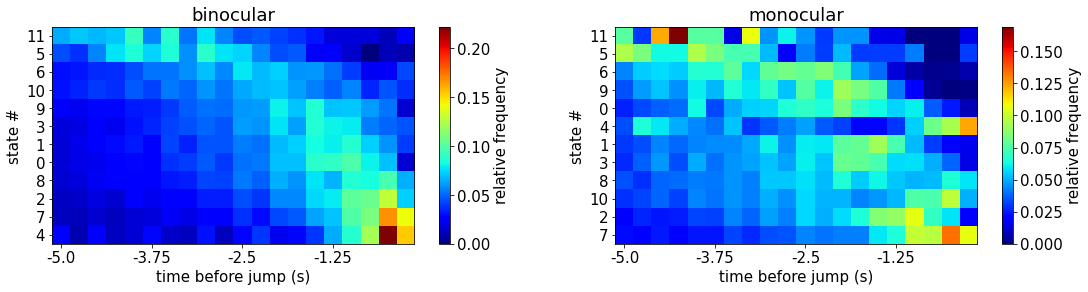

In [33]:
### plot movement timing normalized to the frequency of each movement
fig, axs = plt.subplots(1,2,figsize=(16,4))
axs = axs.ravel()
for c,cond in enumerate(conds):
    df = base_df[base_df[condition]==cond]
    df.reset_index(inplace=True,drop=True)
    state_list = np.array(am.flatten_list(df[state_key_vals].to_list()))
    state_times = np.array(am.flatten_list(df[state_key_times].to_list()))
    n_k = len(np.unique(state_list))-1 #b/c -1 makes it one longer
    trunc_list = state_list[state_times>bin_min]
    trunc_times = state_times[state_times>bin_min]
    bins= np.arange(bin_min,bin_step,bin_step)
    st_hist = np.zeros((n_k,int(np.abs(bin_min/bin_step))))
    mn_t = []
    for s in range(n_k):
        t = trunc_times[np.where(trunc_list==s)[0]]
        hist = np.histogram(t,bins=bins)[0]
        st_hist[s,:] = hist/np.sum(hist)
        mn_t.append(np.median(t))
    mn_t = np.array(mn_t)

    ax = axs[c]
    p0 = ax.imshow(st_hist[np.argsort(mn_t),:],cmap='jet')
    ax.set_xticks(np.arange(0,np.abs(bin_min/bin_step),np.abs(bin_min)))
    ax.set_xticklabels(np.arange(bin_min,0,np.abs(bin_step*bin_min)))
    ax.set_ylabel('state #')
    ax.set_xlabel('time before jump (s)')
    ax.set_yticks(np.arange(0,n_k))
    ax.set_yticklabels(np.argsort(mn_t))
    ax.set_title(cond)
    fig.colorbar(p0,ax=ax,label='relative frequency')

fig.tight_layout()

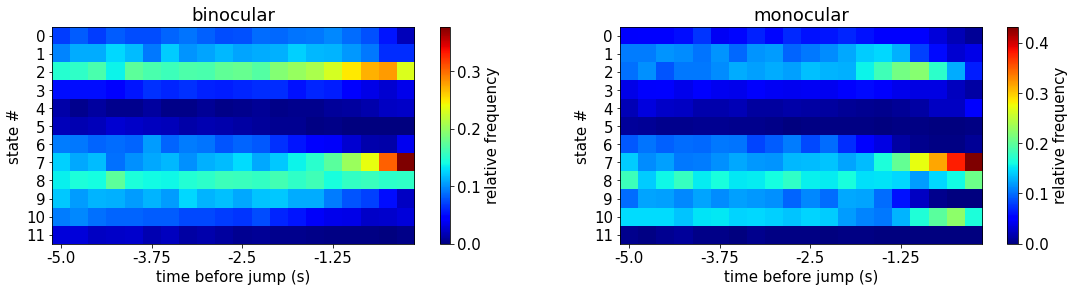

In [42]:
### plot of movement timing normalized to each time bin
fig, axs = plt.subplots(1,2,figsize=(16,4))
axs = axs.ravel()
for c,cond in enumerate(conds):
    df = base_df[base_df[condition]==cond]
    df.reset_index(inplace=True,drop=True)
    state_list = np.array(am.flatten_list(df[state_key_vals].to_list()))
    state_times = np.array(am.flatten_list(df[state_key_times].to_list()))
    n_k = len(np.unique(state_list))-1 #b/c -1 makes it one longer
    trunc_list = state_list[state_times>bin_min]
    trunc_times = state_times[state_times>bin_min]
    bins= np.arange(bin_min,bin_step,bin_step)
    st_hist = np.zeros((n_k,int(np.abs(bin_min/bin_step))))
    mn_t = []
    for s in range(n_k):
        t = trunc_times[np.where(trunc_list==s)[0]]
        hist = np.histogram(t,bins=bins)[0]
        st_hist[s,:] = hist
        mn_t.append(np.median(t))
    mn_t = np.array(mn_t)
    tot = np.sum(st_hist,axis=0)
    for i in range(st_hist.shape[0]):
        st_hist[i,:] /= tot

    ax = axs[c]
    p0 = ax.imshow(st_hist,cmap='jet')
    ax.set_xticks(np.arange(0,np.abs(bin_min/bin_step),np.abs(bin_min)))
    ax.set_xticklabels(np.arange(bin_min,0,np.abs(bin_step*bin_min)))
    ax.set_ylabel('state #')
    ax.set_xlabel('time before jump (s)')
    ax.set_yticks(np.arange(0,n_k))
#     ax.set_yticklabels(np.argsort(mn_t))
    ax.set_title(cond)
    fig.colorbar(p0,ax=ax,label='relative frequency')

fig.tight_layout()

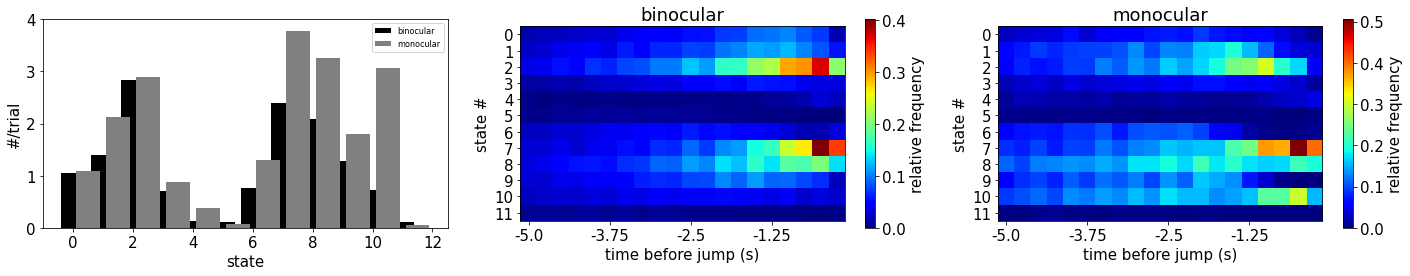

In [32]:
### plot of movement timing normalized to the total number of trials in each condition
plt_col = ['k',[0.5,0.5,0.5]]
fig, axs = plt.subplots(1,3,figsize=(20,4))
axs = axs.ravel()
for c,cond in enumerate(conds):
    df = base_df[base_df[condition]==cond]
    df.reset_index(inplace=True,drop=True)
    state_list = np.array(am.flatten_list(df[state_key_vals].to_list()))
    state_times = np.array(am.flatten_list(df[state_key_times].to_list()))
    n_k = len(np.unique(state_list))-1 #b/c -1 makes it one longer
    trunc_list = state_list[state_times>bin_min]
    trunc_times = state_times[state_times>bin_min]
    bins= np.arange(bin_min,bin_step,bin_step)
    st_hist = np.zeros((n_k,int(np.abs(bin_min/bin_step))))
    mn_t = []
    for s in range(n_k):
        t = trunc_times[np.where(trunc_list==s)[0]]
        hist = np.histogram(t,bins=bins)[0]
        st_hist[s,:] = hist/df.shape[0]
        mn_t.append(np.median(t))
    mn_t = np.array(mn_t)
    
    ax = axs[0]
    ax.bar(np.arange(n_k)+0.5*c,np.sum(st_hist,axis=1),color=plt_col[c],label=cond)
    ax.set_ylabel('#/trial')
    ax.set_xlabel('state')
    ax.set_ylim(0,4)

    ax = axs[c+1]
    p0 = ax.imshow(st_hist,cmap='jet')#[np.argsort(mn_t),:]
    ax.set_xticks(np.arange(0,np.abs(bin_min/bin_step),np.abs(bin_min)))
    ax.set_xticklabels(np.arange(bin_min,0,np.abs(bin_step*bin_min)))
    ax.set_ylabel('state #')
    ax.set_xlabel('time before jump (s)')
    ax.set_yticks(np.arange(0,n_k))
#     ax.set_yticklabels(np.argsort(mn_t))
    ax.set_title(cond)
    fig.colorbar(p0,ax=ax,label='relative frequency')
axs[0].legend(fontsize=8)
    
fig.tight_layout()


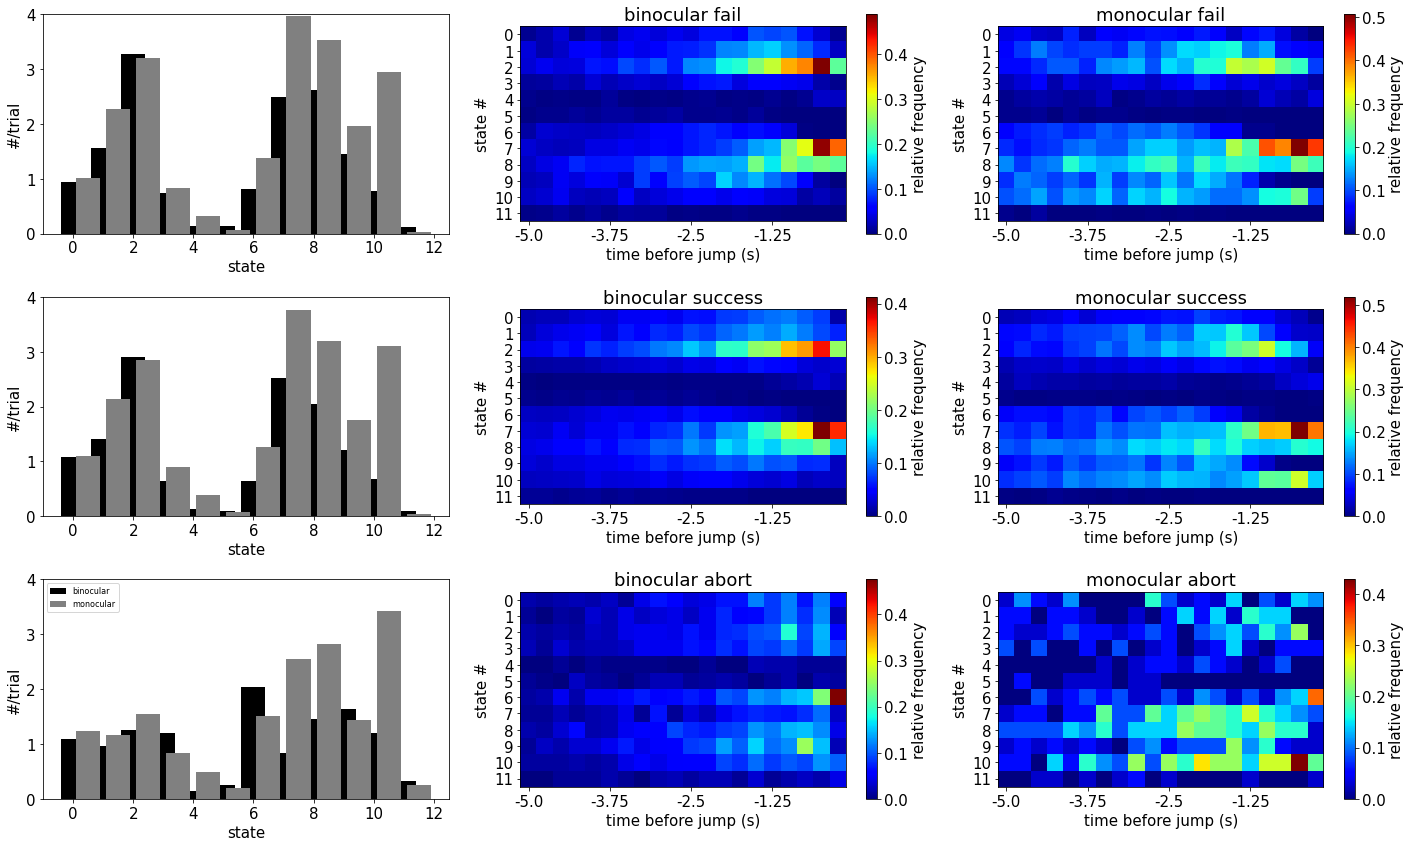

In [47]:
### plot of movement timing normalized to the total number of trials in each condition
plt_col = ['k',[0.5,0.5,0.5]]
suc_lab = ['fail','success','abort']
fig, axs = plt.subplots(3,3,figsize=(20,12))
# axs = axs.ravel()
for suc in np.unique(base_df['success']):
    for c,cond in enumerate(conds):
        df = base_df[(base_df[condition]==cond)&(base_df['success']==suc)]
        df.reset_index(inplace=True,drop=True)
        state_list = np.array(am.flatten_list(df[state_key_vals].to_list()))
        state_times = np.array(am.flatten_list(df[state_key_times].to_list()))
        n_k = len(np.unique(state_list))-1 #b/c -1 makes it one longer
        trunc_list = state_list[state_times>bin_min]
        trunc_times = state_times[state_times>bin_min]
        bins= np.arange(bin_min,bin_step,bin_step)
        st_hist = np.zeros((n_k,int(np.abs(bin_min/bin_step))))
        mn_t = []
        for s in range(n_k):
            t = trunc_times[np.where(trunc_list==s)[0]]
            hist = np.histogram(t,bins=bins)[0]
            st_hist[s,:] = hist/df.shape[0]
            mn_t.append(np.median(t))
        mn_t = np.array(mn_t)

        ax = axs[suc,0]
        ax.bar(np.arange(n_k)+0.5*c,np.sum(st_hist,axis=1),color=plt_col[c],label=cond)
        ax.set_ylabel('#/trial')
        ax.set_xlabel('state')
        ax.set_ylim(0,4)

        ax = axs[suc,c+1]
        p0 = ax.imshow(st_hist,cmap='jet')#[np.argsort(mn_t),:]
        ax.set_xticks(np.arange(0,np.abs(bin_min/bin_step),np.abs(bin_min)))
        ax.set_xticklabels(np.arange(bin_min,0,np.abs(bin_step*bin_min)))
        ax.set_ylabel('state #')
        ax.set_xlabel('time before jump (s)')
        ax.set_yticks(np.arange(0,n_k))
    #     ax.set_yticklabels(np.argsort(mn_t))
        ax.set_title(cond + ' ' + suc_lab[suc])
        fig.colorbar(p0,ax=ax,label='relative frequency')
axs[suc,0].legend(fontsize=8) 
fig.tight_layout()


In [3]:
#bins are hard coded right now
tjump_histrange = [-5,0]
tstart_histrange = [0,1]
bins= -int(tjump_histrange[0])*2

#first calculate the times for each animal/condition/distance
tjump = np.zeros((len(anis),len(conds),n_k,bins))
tstart = np.zeros((len(anis),len(conds),n_k,bins))
for a,ani in enumerate(anis):
    for c,cond in enumerate(conds):
        for k in range(n_k):
            tr_idx = np.intersect1d(np.where(df['subject']==ani)[0],
                                          np.intersect1d(np.where(df[cluster_key]==k)[0],
                                                         np.intersect1d(np.where(df[condition]==cond)[0],
                                                                        np.where(df['success']==1)[0])))
            tjump[a,c,k,:] = np.histogram(df[side + '_mov_rel_jump'][tr_idx],
                                          bins=bins,range=tjump_histrange)[0]/len(df[side + '_mov_rel_jump'][tr_idx])
            tstart[a,c,k,:] = np.histogram(df[side + '_mov_rel_start'][tr_idx],
                                           bins=bins,range=tstart_histrange)[0]/len(df[side + '_mov_rel_start'][tr_idx])

#then plot the results for time from jump
fig, axs = plt.subplots(1,len(conds),figsize=(10*len(conds),10))
if len(conds)>1:
    axs = axs.ravel()
else:
    ax = axs

for c,cond in enumerate(conds):
    if len(conds)>1:
        ax = axs[c]
    hist = np.nanmean(tjump[:,c,:,:],axis=0)
    pos = ax.imshow(hist,cmap=plot_params['cm'])
    ax.set_xticks(np.arange(0,10,2))
    ax.set_xticklabels(np.arange(tjump_histrange[0],tjump_histrange[1]+1,2))
    ax.set_title(cond)
    ax.set_xlabel('time before jump (s)')
    ax.set_ylabel('movement type')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(pos, cax=cax, orientation='vertical')
cbar.ax.set_ylabel('normalized movement frequency',rotation=90,fontsize=15)

In [ ]:
### plot all states during decision period
pdf_file = r'C:\Users\nlab\Box Sync\Phil Niell Lab\Behavior\Jumping task\analysis\arhmm_decision_plots.pdf'
pp = PdfPages(pdf_file)

vid_dir = r'\\sendak\D\Phil\jumping_analysis\paper_cohort\clipped_vids'
ts_down = 2

jet = cm.get_cmap('jet',K)
new_cols = jet(np.linspace(0, 1, K))
cmap = discrete_cmap(K,base_cmap=plt.cm.jet)
for index, row in base_df.iterrows():
    strial_trMAPs = row['trMAPs']
    
    fig, ax = plt.subplots(1,1)
    fname = am.vidname_from_row(vid_dir,'Side',row)
    frame,fps,frame_width,frame_height = am.grab_vidframe(fname,row['Side_Jump']-row['Side_Start']-2)
    ax.imshow(frame)
    xtr,ytr = filter_decision_period(row,'Side','LEye',0.95,ts_down)
#     p0 = ax.plot(xtr,ytr,':',color=[0.2,0.2,0.2],linewidth=1)
    p1 = ax.scatter(xtr, ytr, s=4, c=strial_trMAPs, cmap=cmap, zorder=1)
    for p in range(len(xtr)-1):
        ax.plot([xtr[p],xtr[p+1]],[ytr[p],ytr[p+1]],'-',color=new_cols[strial_trMAPs[p],:],linewidth=0.5)
    cb = add_colorbar(p1)
    cb.outline.set_linewidth(1)
    ax.axis('off')
    ax.axis([frame_width*(2/3),frame_width*(7/8),frame_height*(2/3),frame_height*(4/9)])
    fig.suptitle('%s %s trial %s' % (row['expdate'],row['subject'],row['trial']),fontsize=15)
    fig.tight_layout()
    pp.savefig(fig)
    plt.close(fig)
pp.close()

In [5]:
### plot each state individually during the decision period
pdf_file = r'C:\Users\nlab\Box Sync\Phil Niell Lab\Behavior\Jumping task\analysis\arhmm_singleState_decision_plots.pdf'
pp = PdfPages(pdf_file)

vid_dir = r'\\sendak\D\Phil\jumping_analysis\paper_cohort\clipped_vids'
ts_down = 2

for index, row in base_df.iterrows():
    strial_trMAPs = row['trMAPs']
    fname = am.vidname_from_row(vid_dir,'Side',row)
    frame,fps,frame_width,frame_height = am.grab_vidframe(fname,row['Side_Jump']-row['Side_Start']-2)
    xtr,ytr = filter_decision_period(row,'Side','LEye',0.95,ts_down)
    buf = 30
    xmin = int(np.min(xtr)-buf)
    xmax = int(np.max(xtr)+buf)
    ymin = int(np.min(ytr)-buf)
    ymax = int(np.max(ytr)+buf)

    nrows = int(np.ceil(K/3))
    ncols = int(np.ceil(K/4))
    fac = 2
    fig, axs = plt.subplots(nrows,ncols,figsize=(fac*ncols,fac*nrows))
    axs = axs.ravel()
    for st in range(K):
        ax = axs[st]
        if st in strial_trMAPs:
            ax.imshow(frame)
            ax.plot(xtr,ytr,'w',linewidth=0.5)#color=[0.5,0.5,0.5]
            ax.plot(xtr[0],ytr[0],'bP')
            ax.plot(xtr[-1],ytr[-1],'rP')
            Kmap = strial_trMAPs.copy()
            on_inds = np.where(Kmap==st)[0]
            off_inds = np.where(Kmap!=st)[0]
            Kmap[on_inds] = 1
            Kmap[off_inds] = 0
            
#             n, off_seq = split_seqs(off_inds)
            n, on_seq = split_seqs(on_inds)
            for seq in on_seq:
                l = len(seq)
                jet = cm.get_cmap('jet',l)
                new_cols = jet(np.linspace(0, 1, l))
                cmap = discrete_cmap(l,base_cmap=plt.cm.jet)
                c = np.arange(l)
                p1 = ax.scatter(xtr[seq], ytr[seq], s=5, c=c, cmap=cmap, zorder=1)
                for p in range(len(xtr[seq])-1):
                    ax.plot([xtr[seq[p]],xtr[seq[p+1]]],[ytr[seq[p]],ytr[seq[p+1]]],'-',color=new_cols[c[p],:],linewidth=1)
#             cb = add_colorbar(p1)
#             cb.outline.set_linewidth(1)
            ax.axis('off')
            ax.axis([xmin,xmax,ymax,ymin])
#             ax.axis([frame_width*(2/3),frame_width*(7/8),frame_height*(2/3),frame_height*(4/9)])
            ax.set_title('state %d' % st,fontsize=8)
        else:
            ax.axis('off')
    fig.suptitle('%s %s trial %s' % (row['expdate'],row['subject'],row['trial']),fontsize=10)
    fig.tight_layout()
    pp.savefig(fig)
    plt.close(fig)
pp.close()

In [89]:
### plot the trajectory of the head during the decision period
pdf_file = r'C:\Users\nlab\Box Sync\Phil Niell Lab\Behavior\Jumping task\analysis\all_decision_plots.pdf'
pp = PdfPages(pdf_file)

vid_dir = r'\\sendak\D\Phil\jumping_analysis\paper_cohort\clipped_vids'
for index,row in df.iterrows():
    fig, ax = plt.subplots(1,1)
    fname = am.vidname_from_row(vid_dir,'Side',row)
    frame,fps,frame_width,frame_height = am.grab_vidframe(fname,row['Side_Jump']-row['Side_Start'])
    ax.imshow(frame)
    ax.axis('off')
    xtr,ytr = filter_decision_period(row,'Side','LEye',0.95)
    ax.plot(xtr,ytr,'m')
    ax.plot(xtr[0],ytr[0],'bo')
    ax.plot(xtr[-1],ytr[-1],'ro')
    ax.axis([frame_width*(2/3),frame_width*(7/8),frame_height*(2/3),frame_height*(4/9)])
    fig.suptitle('%s %s trial %s' % (row['expdate'],row['subject'],row['trial']),fontsize=8)
    fig.tight_layout()
    pp.savefig(fig)
    plt.close(fig)
pp.close()

NameError: name 'df' is not defined

# Create performance PDF in each K folder for a model

In [52]:
def plot_individual_states(K,index,row,vid_dir,ts_down,pp):
    strial_trMAPs = row['trMAPs']
    fname = am.vidname_from_row(vid_dir,'Side',row)
    frame,fps,frame_width,frame_height = am.grab_vidframe(fname,row['Side_Jump']-row['Side_Start']-2)
    xtr,ytr = filter_decision_period(row,'Side','LEye',0.95,ts_down)
    buf = 30
    xmin = int(np.min(xtr)-buf)
    xmax = int(np.max(xtr)+buf)
    ymin = int(np.min(ytr)-buf)
    ymax = int(np.max(ytr)+buf)

    nrows = int(np.ceil(K/3))
    ncols = 3
    fac = 3
    fig, axs = plt.subplots(nrows,ncols,figsize=(fac*ncols,fac*nrows))
    axs = axs.ravel()
    for st in range(K):
        ax = axs[st]
        if st in strial_trMAPs:
            ax.imshow(frame)
            ax.plot(xtr,ytr,'w',linewidth=0.5)#color=[0.5,0.5,0.5]
            ax.plot(xtr[0],ytr[0],'bP')
            ax.plot(xtr[-1],ytr[-1],'rP')
            Kmap = strial_trMAPs.copy()
            on_inds = np.where(Kmap==st)[0]
            off_inds = np.where(Kmap!=st)[0]
            Kmap[on_inds] = 1
            Kmap[off_inds] = 0
            
#             n, off_seq = split_seqs(off_inds)
            n, on_seq = split_seqs(on_inds)
            for seq in on_seq:
                l = len(seq)
                jet = cm.get_cmap('jet',l)
                new_cols = jet(np.linspace(0, 1, l))
                cmap = discrete_cmap(l,base_cmap=plt.cm.jet)
                c = np.arange(l)
                p1 = ax.scatter(xtr[seq], ytr[seq], s=5, c=c, cmap=cmap, zorder=1)
                for p in range(len(xtr[seq])-1):
                    ax.plot([xtr[seq[p]],xtr[seq[p+1]]],[ytr[seq[p]],ytr[seq[p+1]]],'-',color=new_cols[c[p],:],linewidth=1)
#             cb = add_colorbar(p1)
#             cb.outline.set_linewidth(1)
            ax.axis('off')
            ax.axis([xmin,xmax,ymax,ymin])
#             ax.axis([frame_width*(2/3),frame_width*(7/8),frame_height*(2/3),frame_height*(4/9)])
            ax.set_title('state %d' % st,fontsize=8)
        else:
            ax.axis('off')
    fig.suptitle('%s %s trial %s' % (row['expdate'],row['subject'],row['trial']),fontsize=10)
    fig.tight_layout()
    pp.savefig(fig)
    plt.close(fig)


In [13]:
def PlotPerformance(base_df, conditions=['control','suture'], K=12, pmask=None, pp=None, FigurePath=None, lg_loc=['center left','upper right']):
    ''' 
    Function to create plots of performance against each state.
    
    ## Inputs
    df:         DataFrame containing ['subject','condition','success','distance']
    conditions: List of conditions of the experiment
    K:          Number of states
    pp:         pdf page writer
    pmask:      Mask of when each state is present. dim: (Trials, K)
    FigurePath: Path location for saving figures
    lg_loc:     List of locations for legends in plots
    '''
    
    ##### Matplotlib settings for plotting #####
#     import matplotlib.patches as mpatches
#     from matplotlib.lines import Line2D
#     import matplotlib as mpl
#     mpl.rcParams.update({'font.size': 24})
#     mpl.rcParams.update({'axes.linewidth': 5}) 
#     mpl.rcParams['xtick.major.size'] = 10
#     mpl.rcParams['xtick.major.width'] = 4
#     mpl.rcParams['ytick.major.size'] = 10
#     mpl.rcParams['ytick.major.width'] = 4
#     mpl.rcParams['axes.spines.right'] = False
#     mpl.rcParams['axes.spines.top'] = False
#     mpl.rcParams['font.sans-serif'] = "Arial"
#     mpl.rcParams['font.family'] = "sans-serif"
    ### Creting Legend hanldes ###
    red_patch = mpatches.Patch(color='red', label='Fails')
    green_patch = mpatches.Patch(color='green', label='Successes')
    blue_patch = mpatches.Patch(color='blue', label='Aborts')
    Line = [Line2D([0],[0], color='k', LineStyle='-'),
            Line2D([0],[0], color='k', LineStyle='--')]
    
    # Start Plotting
    df = base_df.copy()
    df['success2'] = df['success'].copy()
    N = len(df['subject'].unique()) # Number of animals for ste
    for condition in conditions: # loop over conditions
        fig2, axs = plt.subplots(int(np.ceil(K/3)),3, figsize=(3*5,int(np.ceil(K/3))*5), sharey=True)
        axs = axs.flatten()
        for state in range(K): # Loop over states
            df_state    = df[['subject','condition','success','distance','success2']].iloc[pmask[:,state]].groupby(['subject','condition','distance','success']).count().unstack(fill_value=0).stack()
            df_count    = df_state.copy().groupby('condition').sum()
            df_state    = df_state/df_state.groupby(['condition','subject','distance']).sum()
            state_ste   = df_state.groupby(['condition','distance','success']).std()/np.sqrt(N)
            df_state    = df_state.groupby(['condition','distance','success']).mean()
            df_nostate  = df[['subject','condition','success','distance','success2']].iloc[~pmask[:,state]].groupby(['subject','condition','distance','success']).count().unstack(fill_value=0).stack()
            df_count2   = df_nostate.copy().groupby('condition').sum()
            df_nostate  = df_nostate/df_nostate.groupby(['condition','subject','distance']).sum()
            nostate_ste = df_nostate.groupby(['condition','distance','success']).std()/np.sqrt(N)
            df_nostate  = df_nostate.groupby(['condition','distance','success']).mean()


            dists = df_state.index.unique('distance').values.squeeze()
            try:
                pl1a = axs[state].errorbar(x=dists,y=df_state.xs([condition,0],level=[0,2]).values, yerr=state_ste.xs([condition,0],level=[0,2]).values.squeeze(), c='r', ls='-', lw=3)
                pl1b = axs[state].errorbar(x=dists,y=df_state.xs([condition,1],level=[0,2]).values, yerr=state_ste.xs([condition,1],level=[0,2]).values.squeeze(), c='g', ls='-', lw=3)
                pl1c = axs[state].errorbar(x=dists,y=df_state.xs([condition,2],level=[0,2]).values, yerr=state_ste.xs([condition,2],level=[0,2]).values.squeeze(), c='b', ls='-', lw=3)
            except:
                pass
            
            dists2 = df_nostate.index.unique('distance').values.squeeze()
            try:
                pl2a = axs[state].errorbar(x=dists2,y=df_nostate.xs([condition,0],level=[0,2]).values, yerr=nostate_ste.xs([condition,0],level=[0,2]).values.squeeze(), c='r', ls='--', lw=3)
                pl2b = axs[state].errorbar(x=dists2,y=df_nostate.xs([condition,1],level=[0,2]).values, yerr=nostate_ste.xs([condition,1],level=[0,2]).values.squeeze(), c='g', ls='--', lw=3)
                pl2c = axs[state].errorbar(x=dists2,y=df_nostate.xs([condition,2],level=[0,2]).values, yerr=nostate_ste.xs([condition,2],level=[0,2]).values.squeeze(), c='b', ls='--', lw=3)
            except:
                pass
            
            try:
                wProp = [(df_count.xs(condition)/(df_count.xs(condition)+df_count2.xs(condition))).values[0],(df_count2.xs(condition)/(df_count.xs(condition)+df_count2.xs(condition))).values[0]]
            except:
                pass
            axs[state].set_title('State {}, w/={:.02f}, w/o={:.02f}'.format(state,wProp[0],wProp[1]))
            axs[state].set_xlabel('Distance (cm)')
            if state%3 == 0:
                axs[state].set_ylabel('Avg %')
        lg1 = axs[0].legend(handles = [red_patch,green_patch,blue_patch], labels=['Fails','Successes','Aborts'], loc='center left')
        axs[0].legend(handles = [Line[0],Line[1]],labels=['w/ state ','w/o state '], loc='upper right')
        axs[0].add_artist(lg1)
        suptitle = plt.suptitle('Condition: {}'.format(condition),y=1.01, fontsize=40)
        for ax in axs:
            ax = am.xy_axis(ax)
        plt.tight_layout()
        if pp is None:
            fig2.savefig(os.path.join(FigurePath,'Performace_Avg_{}.png'.format(condition)),dpi=fig2.dpi, bbox_inches='tight',bbox_extra_artists=[suptitle])
        else:
            pp.savefig(dpi=fig2.dpi, bbox_inches='tight',bbox_extra_artists=[suptitle])
        plt.close()
        


def PlotAccuracy(base_df, conditions=['control','suture'], Performance=1, K=12, pmask=None, pp=None, FigurePath=None, lg_loc=['center left','upper right']):
    ''' 
    Function to create plots of performance against each state.
    
    ## Inputs
    df:         DataFrame containing ['subject','condition','success','distance']
    conditions: List of conditions of the experiment
    K:          Number of states
    pp:         pdf page writer
    pmask:      Mask of when each state is present. dim: (Trials, K)
    FigurePath: Path location for saving figures
    lg_loc:     List of locations for legends in plots
    '''
    
    ##### Matplotlib settings for plotting #####
#     import matplotlib.patches as mpatches
#     from matplotlib.lines import Line2D
#     import matplotlib as mpl
#     mpl.rcParams.update({'font.size': 24})
#     mpl.rcParams.update({'axes.linewidth': 5}) 
#     mpl.rcParams['xtick.major.size'] = 10
#     mpl.rcParams['xtick.major.width'] = 4
#     mpl.rcParams['ytick.major.size'] = 10
#     mpl.rcParams['ytick.major.width'] = 4
#     mpl.rcParams['axes.spines.right'] = False
#     mpl.rcParams['axes.spines.top'] = False
#     mpl.rcParams['font.sans-serif'] = "Arial"
#     mpl.rcParams['font.family'] = "sans-serif"
    ### Creting Legend hanldes ###
    red_patch = mpatches.Patch(color='red', label='Fails')
    green_patch = mpatches.Patch(color='green', label='Successes')
    blue_patch = mpatches.Patch(color='blue', label='Aborts')
    Line = [Line2D([0],[0], color='k', LineStyle='-'),
            Line2D([0],[0], color='k', LineStyle='--')]
    cl = ['r','g','b']    
    # Start Plotting
    df = base_df.copy()
    df['success2'] = df['success'].copy()
    N = len(df['subject'].unique()) # Number of animals for ste
    for condition in conditions: # loop over conditions
        fig2, axs = plt.subplots(int(np.ceil(K/3)),3, figsize=(3*5,int(np.ceil(K/3))*5), sharey=True)
        axs = axs.flatten()
        for state in range(K): # Loop over states
            df_state    = df[['subject','condition','success','distance','accuracy']].iloc[(pmask[:,state]) & (df['success'].values==Performance)].groupby(['subject','condition','distance','success']).mean().unstack('distance').groupby(['condition','success']).agg(np.nanmean).fillna(0).stack().replace(0, np.nan)
            state_ste   = (df[['subject','condition','success','distance','accuracy']].iloc[(pmask[:,state]) & (df['success'].values==Performance)].groupby(['condition','distance','success']).agg(np.nanstd)/np.sqrt(N)).unstack('distance').fillna(0).stack().replace(0, np.nan)
            df_nostate  = df[['subject','condition','success','distance','accuracy']].iloc[(~pmask[:,state]) & (df['success'].values==Performance)].groupby(['subject','condition','distance','success']).mean().unstack('distance').groupby(['condition','success']).agg(np.nanmean).fillna(0).stack().replace(0, np.nan)
            nostate_ste = (df[['subject','condition','success','distance','accuracy']].iloc[(~pmask[:,state]) & (df['success'].values==Performance)].groupby(['condition','distance','success']).agg(np.nanstd)/np.sqrt(N)).unstack('distance').fillna(0).stack().replace(0, np.nan)

            dists = df_state.index.unique('distance').values.squeeze()
            dists2 = df_nostate.index.unique('distance').values.squeeze()
            try:
                pl1a = axs[state].errorbar(x=dists,y=df_state.xs([condition,Performance],level=[0,1]).values, yerr=state_ste.xs([condition,Performance],level=[0,1]).values.squeeze(), c=cl[Performance], ls='-', lw=3)
            except:
                pass
            
            try:
                pl2a = axs[state].errorbar(x=dists2,y=df_nostate.xs([condition,Performance],level=[0,1]).values, yerr=nostate_ste.xs([condition,Performance],level=[0,1]).values.squeeze(), c=cl[Performance], ls='--', lw=3)
            except:
                pass
            
            axs[state].set_title('State {}'.format(state))
            axs[state].set_xlabel('Distance (cm)')
            if state%3 == 0:
                axs[state].set_ylabel('Avg Accuracy')
        lg1 = axs[0].legend(handles = [red_patch,green_patch,blue_patch], labels=['Fails','Successes','Aborts'], loc='center left')
        axs[0].legend(handles = [Line[0],Line[1]],labels=['w/ state', 'w/o state'], loc='upper right')
        axs[0].add_artist(lg1)
        suptitle = plt.suptitle('Condition: {}'.format(condition),y=1.01, fontsize=40)
        for ax in axs:
            ax = am.xy_axis(ax)
        plt.tight_layout()
        if pp is None:
            fig2.savefig(os.path.join(FigurePath,'Accuracy_{}_{}.png'.format(Performance,condition)),dpi=fig2.dpi, bbox_inches='tight',bbox_extra_artists=[suptitle])
        else:
            pp.savefig(dpi=fig2.dpi, bbox_inches='tight',bbox_extra_artists=[suptitle])
        plt.close()

In [37]:
idx = 200
row = base_df.iloc[idx]
xtr,ytr = am.filter_decision_period(row,'Side','LEye',0.95,ts_down)
state_list = row['trMAPs'].copy()
state_list[~row['trMasks']] = -1
state_list

array([-1, -1,  3,  3,  3,  3,  3,  3, -1, -1,  0,  0,  0,  0,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  2,  2,  2,  2,  2,
        2, -1, -1, -1,  3,  3,  3,  3,  3,  3,  3,  3,  3, -1, -1,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3, -1, -1, -1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  3,  3,  3,  3, -1,  5,  5,  5,
        5,  5,  5,  5, -1, -1, -1,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,
        0,  0,  0,  0,  0,  0,  0, -1,  2,  2,  2,  2,  2, -1, -1, -1, -1,
       -1, -1], dtype=int64)

In [40]:
st_inds = list(np.where(state_list==0)[0])
st_inds

[10, 11, 12, 13, 135, 136, 137, 138, 139, 140, 141, 142]

(<Figure size 648x432 with 6 Axes>,
 array([<AxesSubplot:title={'center':'state 0'}>,
        <AxesSubplot:title={'center':'state 1'}>,
        <AxesSubplot:title={'center':'state 2'}>,
        <AxesSubplot:title={'center':'state 3'}>,
        <AxesSubplot:title={'center':'state 4'}>,
        <AxesSubplot:title={'center':'state 5'}>], dtype=object))

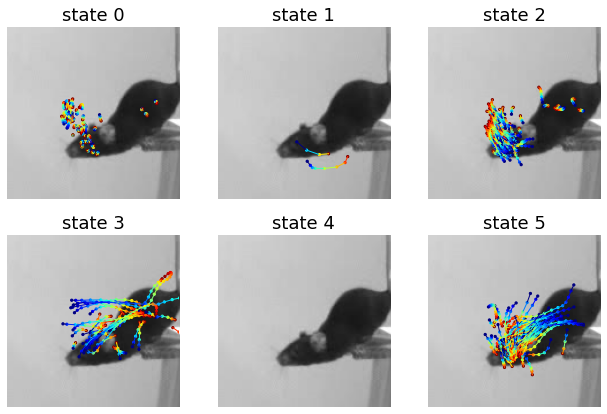

In [ ]:
vid_dir = r'\\sendak\D\Phil\jumping_analysis\paper_cohort\clipped_vids'
ts_down = 2

#pick a random subset of trials


nrows = int(np.ceil(K/3))
ncols = int(np.ceil(K/4))
fac = 2
fig, axs = plt.subplots(nrows,ncols,figsize=(fac*ncols,fac*nrows))
axs = axs.ravel()

for index, row in base_df.iterrows():
    if index==0:
        fname = am.vidname_from_row(vid_dir,'Side',row)
        frame,fps,frame_width,frame_height = am.grab_vidframe(fname,row['Side_Jump']-row['Side_Start']-2)
        buf = 30
        xmin = int(np.min(xtr)-buf)
        xmax = int(np.max(xtr)+buf)
        ymin = int(np.min(ytr)-buf)
        ymax = int(np.max(ytr)+buf)

    
    
    xtr,ytr = filter_decision_period(row,'Side','LEye',0.95,ts_down)
    for st in range(K):
        ax = axs[st]
        if st in strial_trMAPs:
            ax.imshow(frame)

finished saving pdf model 1/6 K 1/1


# Plot individual animal data for one model/K

In [10]:
###### pick a folder below (KDir) and loop through all the values of K run with that model
top_dir = r'\\sendak\D\Phil\jumping_analysis\paper_cohort\ARHMM\*'
models = glob(top_dir)
Krange = np.arange(6,17) # the range of values used for K in the analysis
K=12
# for m_num,model in enumerate(models):
#     for Kind,K in enumerate(Krange):
KDir = os.path.join(models[0],'K-%s' % str(K).zfill(2))
fpath = glob(os.path.join(KDir,'MAP_seqs*.h5'))[0]
trMAPs, trPosteriors, trMasks, arhmm_params, opt = ioh5.load_MAP_seqs_h5(fpath)

trMasks2 = []
tBins_removed = []
for iTrial, mapseq in enumerate(trMAPs):
    #Apply posterior probability threshold mask
    MAPcp = mapseq.copy()
    mask = trMasks[iTrial]
    MAPcp[~mask] = -1
    #Loop over states and NaN out that were less than 100ms (3 frames)
    for state in range(K):
        state_1hot = np.concatenate(([0],(np.array(MAPcp) == state).astype(int),[0]))
        state_trans = np.diff(state_1hot)
        state_ends = np.nonzero(state_trans == -1)[0]
        state_starts = np.nonzero(state_trans == +1)[0]
        state_durations = state_ends - state_starts
        #State was not used this trial
        if len(state_durations) == 0:
            continue
        #Loop over the individual state sequences and NaN out the short ones
        for iSeq, sd in enumerate(state_durations):
            if sd <= 3: #3 frames, so 90ms for 2x downsampled data
                MAPcp[slice(state_starts[iSeq],state_ends[iSeq])] = -1
    #Update mask
    mask2 = MAPcp != -1
    trMasks2.append(mask2)
    #See how much of a difference that made
    tBins_removed.append(np.sum(mask)-np.sum(mask2))


n_k = 12 # number of clusters in the dataset
df_file = r'\\sendak\C\Users\nlab\Box Sync\Phil Niell Lab\Behavior\Jumping task\analysis\paper_cohort_alldata_500msClusts_df_%dclusts.h5' % n_k
labels_file = r'\\sendak\C\Users\nlab\Box Sync\Phil Niell Lab\Behavior\Jumping task\analysis\paper_cohort_alldata_500msClusts_labels_%dclusts.h5' % n_k
df_all = pd.read_hdf(df_file)
labels_all = pd.read_hdf(labels_file)
df_all['trMAPs'] = trMAPs
df_all['trPosteriors'] = trPosteriors
df_all['trMasks'] = trMasks2 # note which version of masking you want

### baseline (no opto) data
base_df = df_all.copy()
base_df = base_df[base_df['laser_trial']!=1]
base_df.reset_index(inplace=True,drop=True)
base_df[base_df['condition']=='opto suture'] = base_df[base_df['condition']=='opto suture'].replace('opto suture','suture')
base_df = am.get_jump_accuracy(base_df)
# base_df = aborts_as_failures(base_df)
# base_df = remove_aborts(base_df)


base_labels = labels_all.copy()
base_labels = base_labels[base_labels['laser_trial']!=1]
base_labels.reset_index(inplace=True,drop=True)
base_labels[base_labels['condition']=='opto suture'] = base_labels[base_labels['condition']=='opto suture'].replace('opto suture','suture')
base_labels = am.get_movement_amplitudes_mm(base_labels,'Side')
# base_labels = aborts_as_failures(base_labels)
# base_labels = remove_aborts(base_labels)

#         print('finished loading data')
anis = np.unique(base_df['subject'])
for a,ani in enumerate(anis):
    pdf_file = os.path.join(KDir,'hmm_%d_performance_100ms_min_state_duration_%s.pdf' % (K,ani))
    pp = PdfPages(pdf_file)
    save_pdf = True
    dur = 0 # min state duration
    
    ani_df = base_df[base_df['subject']==ani]
    ani_df.reset_index(inplace=True,drop=True)
    for hmm_k in range(K):
        hmm_trial = []
        hmm_freq = []
        for index,row in ani_df.iterrows():
            row['trMAPs'][np.logical_not(row['trMasks'])]=-1 #set low prob MAPs to -1
            n_seq = am.num_seq_in_list(np.where(row['trMAPs']==hmm_k)[0].tolist(),dur,row['fps'])
            hmm_freq.append(n_seq)
            if n_seq>=1:
                hmm_trial.append(1)
            else:
                hmm_trial.append(0)

        ani_df['hmm_trial'] = hmm_trial
        ani_df['hmm_freq'] = hmm_freq

        am.plot_hmm_stats(ani_df,'ocular','hmm_trial',save_pdf,pp,'%s State %d' % (ani,hmm_k))

    pp.close()

    print('finished saving pdf animal %d/%d' % (a+1,len(anis)))

finished saving pdf animal 1/8
finished saving pdf animal 2/8
finished saving pdf animal 3/8
finished saving pdf animal 4/8
finished saving pdf animal 5/8
finished saving pdf animal 6/8
finished saving pdf animal 7/8
finished saving pdf animal 8/8


# Old stuff below

In [4]:
# ### for wyrick, add labels for individual movements
# def add_arhmm_to_labels(df,labels):
#     Side_trMAPs_eye_mvmnt, Side_trPosteriors_eye_mvmnt, Side_trMasks_eye_mvmnt = ([] for i in range(3))
#     for index, labels_row in labels.iterrows():
#         df_row = df_row_from_labels(df,labels_row) #get corresponding row in df
#         df_row['trMAPs'][np.logical_not(df_row['trMasks'])]=-1 #set low prob MAPs to -1
#         Side_trMAPs_eye_mvmnt.append(df_row['trMAPs'][int(labels_row['Side_windows']):int(labels_row['Side_windows'] + df_row['fps']*1.5)])
#         Side_trPosteriors_eye_mvmnt.append(df_row['trPosteriors'][int(labels_row['Side_windows']):int(labels_row['Side_windows'] + df_row['fps']*1.5)])
#         Side_trMasks_eye_mvmnt.append(df_row['trMasks'][int(labels_row['Side_windows']):int(labels_row['Side_windows'] + df_row['fps']*1.5)])
#     labels['Side_trMAPs_eye_mvmnt'] = Side_trMAPs_eye_mvmnt
#     labels['Side_trPosteriors_eye_mvmnt'] = Side_trPosteriors_eye_mvmnt
#     labels['Side_trMasks_eye_mvmnt'] = Side_trMasks_eye_mvmnt
    
#     return labels

# labels_all = add_arhmm_to_labels(df_all,labels_all)
# h5file = r'C:\Users\nlab\Box Sync\Phil Niell Lab\Behavior\Jumping task\analysis\jumping_hierarchicalmovements_102920.h5'
# labels_all.to_hdf(h5file,key='labels_all',mode='w')
# print('finished saving data!')

SyntaxError: invalid syntax (<ipython-input-4-95197b8145c0>, line 16)

# Generate and save plots

In [3]:
pdf_file = os.path.join(KDir,'hmm_%d_performance_100ms_min_state_duration.pdf' % K)
pp = PdfPages(pdf_file)
save_pdf = True
dur = 0 # min state duration
for hmm_k in range(K):
    hmm_trial = []
    hmm_freq = []
    for index,row in base_df.iterrows():
        row['trMAPs'][np.logical_not(row['trMasks'])]=-1 #set low prob MAPs to -1
        n_seq = num_seq_in_list(np.where(row['trMAPs']==hmm_k)[0].tolist(),dur,row['fps'])
        hmm_freq.append(n_seq)
        if n_seq>0:
            hmm_trial.append(1)
        else:
            hmm_trial.append(0)

    base_df['hmm_trial'] = hmm_trial
    base_df['hmm_freq'] = hmm_freq
    
    plot_hmm_stats(base_df,'ocular','hmm_trial',save_pdf,pp,'State %d' % hmm_k)
    
pp.close()

print('finished saving pdf')

finished saving pdf


In [12]:
row = base_df.iloc[100]
np.where((row['trMAPs']==6) | (row['trMAPs']==11))[0]

array([ 22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,
        35,  36,  37,  43,  44,  45,  46,  47,  69,  70,  71,  72,  73,
        74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,
        87,  88,  89,  90,  91,  92,  93, 123, 124, 125, 145, 146, 147,
       148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160,
       161, 167, 168, 169, 174, 175, 176, 177, 178, 179, 180, 181, 182,
       183, 184, 185, 186, 187], dtype=int64)

In [18]:
pdf_file = r'C:\Users\nlab\Box Sync\Phil Niell Lab\Behavior\Jumping task\analysis\hmm_%d_performance_states_6_11.pdf' % K
pp = PdfPages(pdf_file)
save_pdf = True
dur = 0 # min state duration
# for hmm_k in range(K):
hmm_trial = []
hmm_freq = []
for index,row in base_df.iterrows():
    row['trMAPs'][np.logical_not(row['trMasks'])]=-1 #set low prob MAPs to -1
    if (6 in row['trMAPs']) & (11 in row['trMAPs']):
        n_seq = num_seq_in_list(np.where((row['trMAPs']==6) | (row['trMAPs']==11))[0].tolist(),dur,row['fps'])
        hmm_freq.append(n_seq)
        hmm_trial.append(1)
    else:
        hmm_freq.append(0)
        hmm_trial.append(0)

base_df['hmm_trial'] = hmm_trial
base_df['hmm_freq'] = hmm_freq

plot_hmm_stats(base_df,'ocular','hmm_trial',save_pdf,pp,'States 6 & 11')
    
pp.close()

print('finished saving pdf')

finished saving pdf


<AxesSubplot:>

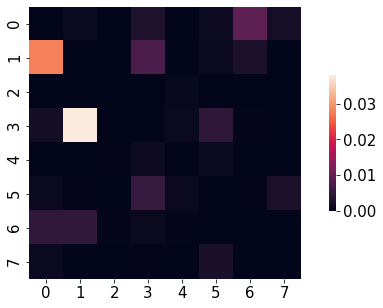

In [3]:
matrix = np.mean(util.get_transition_count_matrices(trMAPs, trMasks, K),axis=0)
for i in range(K):
    matrix[i,i] = 0

plt.figure(figsize=(10,5))
sns.heatmap(matrix, square=True, cbar_kws={'shrink':0.5})

In [6]:
len(np.unique(base_df[manipulation]))

2

In [4]:
save_pdf = True
sides = ['Side','Top']
manipulation = 'bob_trial'
for clust in range(K):
    base_df['bob_trial'] = np.array([clust in MAP for MAP in base_df['trMAPs']]).astype(int)
    pdf_file = r'C:\Users\nlab\Box Sync\Phil Niell Lab\Behavior\Jumping task\analysis\jumping_plots\jumping_plots_hmm_state%d.pdf' % clust
    pp = PdfPages(pdf_file)
    vid_dir = r'D:\Phil\jumping_analysis\paper_cohort\clipped_vids'
    suptitle = 'state %d absent (top) present (bottom)' % clust
    am.plot_jumps(base_df,vid_dir,sides,manipulation,save_pdf,pp,suptitle)
    print('finished %d of %d pdfs' % (int(clust+1),K))

finished 1 of 12 pdfs
finished 2 of 12 pdfs
finished 3 of 12 pdfs
finished 4 of 12 pdfs
finished 5 of 12 pdfs
finished 6 of 12 pdfs
finished 7 of 12 pdfs
finished 8 of 12 pdfs


In [2]:
hmm_file = r'\\sendak\C\Users\nlab\Downloads\preparatory_behavior_K-10_ARHMM.mat'

K = 10
tmp_data = scipy.io.loadmat(hmm_file.format(K))
MAP_list = tmp_data['MAP_list'][0]
posterior_list = tmp_data['posterior_list'][0]
mask_list = tmp_data['mask_list'][0]

In [3]:
h5file = r'C:\Users\nlab\Box Sync\Phil Niell Lab\Behavior\Jumping task\analysis\jumping_data.h5'
df = pd.read_hdf(h5file)

In [4]:
df['MAP_list'] = MAP_list
df['posterior_list'] = posterior_list
df['mask_list'] = mask_list

063020 PV-CHR11P1LT trial= 7 success= 1


(-3.0, 3.0, -3.0, 3.0)

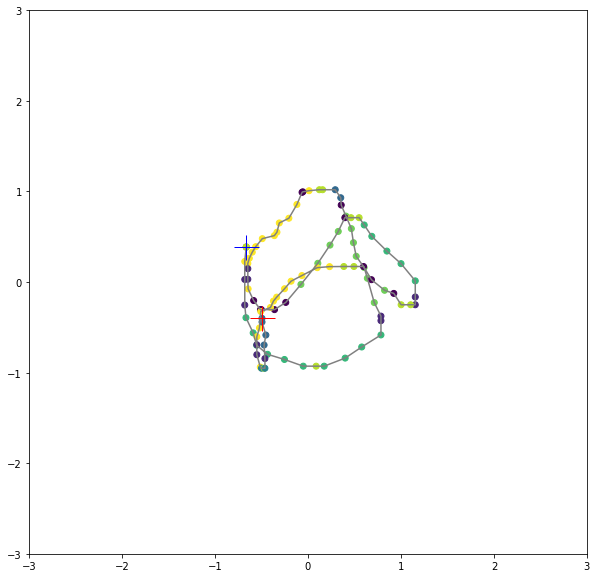

In [5]:
# row = df.iloc[1]
subject = 'PV-CHR11P1LT'
expdate = '063020'
trial = 7

loc = np.where((df['subject']==subject) & (df['expdate']==expdate) & (df['trial']==trial))[0][0]
row = df.iloc[loc]
lim = 3
print(row['expdate'],row['subject'],'trial=',row['trial'],'success=',row['success'])

xtr = row['Side LEye x']/row['Side_pixpercm']
ytr = -row['Side LEye y']/row['Side_pixpercm']
xtr = xtr-np.mean(xtr)
ytr = ytr-np.mean(ytr)
states = np.squeeze(row['MAP_list'])

fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.plot(xtr,ytr,color=[0.5,0.5,0.5])
ax.plot(xtr[0],ytr[0],'b+',markersize=25)
ax.plot(xtr[-1],ytr[-1],'r+',markersize=25)
ax.scatter(xtr,ytr,c=states)
ax.axis([-lim,lim,-lim,lim])
# sns.lineplot(x=xtr,y=ytr,hue=states,ax=ax)

In [9]:
temp_df = df[['expdate','subject']]

,expdate,subject,condition,platform,distance,success,laser_trial,jump_time,trial,fps,...,Top LEar likelihood,Side TakeFL x,Top TakeFL x,Side TakeFL y,Top TakeFL y,Side TakeFL likelihood,Top TakeFL likelihood,MAP_list,posterior_list,mask_list
0,061920,J157BLT,control,2,8,2,laser off,125,1,60,...,"[0.9999997615814209, 0.9999998807907104, 0.999...","[573.0687866210938, 573.0687866210938, 573.068...","[512.955810546875, 513.0393676757812, 513.0393...","[322.8341997502523, 322.61465629322106, 322.61...","[268.1868448211816, 267.6647500946191, 267.522...","[0.999998927116394, 0.9999992847442627, 0.9999...","[0.022194653749465942, 0.013417750597000122, 0...","[[0, 0, 0, 7, 2, -1, 6, -1, 0, 7, 7, 8, -1, -1...","[[0.9745181474171773, 0.025481852556290936, 2....","[[1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,..."
1,061920,J157BLT,control,1,20,2,laser off,222,2,60,...,"[0.9999992847442627, 0.9999996423721313, 0.999...","[572.3963012695312, 572.5952758789062, 572.698...","[522.5081787109375, 524.5397338867188, 525.219...","[322.1634885672048, 321.95636576447043, 321.90...","[312.353937981537, 311.36901366513075, 311.369...","[0.9999996423721313, 0.9999996423721313, 0.999...","[0.04482194781303406, 0.06799852848052979, 0.0...","[[0, 3, 7, 3, 3, -1, -1, -1, -1, 0, 0, 3, 7, 7...","[[0.9833835607225333, 0.016616439217527458, 4....","[[1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,..."
2,061920,J157BLT,control,3,8,1,laser off,355,3,60,...,"[0.9999997615814209, 0.9999997615814209, 0.999...","[572.5652465820312, 572.5652465820312, 572.565...","[524.19970703125, 524.19970703125, 524.1997070...","[321.70764668782556, 321.66675313313806, 321.3...","[290.35496151086056, 290.35496151086056, 289.4...","[0.9999998807907104, 0.9999998211860657, 0.999...","[0.8656889796257019, 0.7850416302680969, 0.630...","[[0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 7, 7, 0,...","[[0.9744830957374814, 0.025516904236184326, 2....","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
3,061920,J157BLT,control,1,12,1,laser off,514,4,60,...,"[0.9999972581863403, 0.9999987483024597, 0.999...","[573.1360473632812, 573.3661499023438, 573.473...","[1.9259750843048096, 265.081298828125, 528.512...","[323.10162814949797, 322.54117282723234, 322.3...","[333.40595751365845, 284.7679875429553, 284.76...","[0.9999951720237732, 0.9999984502792358, 0.999...","[0.004946380853652954, 0.004948854446411133, 0...","[[0, 0, 0, 6, 6, 6, 6, -1, 6, 6, 6, 6, 6, 6, 6...","[[0.97448337007975, 0.02551662989380076, 2.625...","[[1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,..."
4,061920,J157BLT,control,2,12,0,laser off,651,5,60,...,"[0.9999991655349731, 0.9999986886978149, 0.999...","[572.7760009765625, 573.4033813476562, 573.407...","[522.1571655273438, 522.1571655273438, 522.157...","[320.158985665174, 319.99281745228336, 319.964...","[291.3589452728023, 291.3589452728023, 291.358...","[0.9999997615814209, 0.9999998807907104, 0.999...","[0.9386019706726074, 0.956940770149231, 0.9827...","[[0, 0, 0, 6, 6, 6, 6, 2, 2, 2, 7, 2, 2, 2, 7,...","[[0.9744830445867457, 0.02551695538684723, 2.6...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4259,072420,PV-CHR11P2RT,opto suture,1,24,2,laser off,1571,20,60,...,"[0.9991035461425781, 0.9992549419403076, 0.998...","[571.9061889648438, 572.0847778320312, 572.205...","[513.6566162109375, 513.802001953125, 513.8020...","[324.17052942543216, 323.48592859535404, 323.3...","[289.4977499551819, 289.02597871494754, 289.02...","[0.9999986886978149, 0.9999974370002747, 0.999...","[0.9900064468383789, 0.9893888235092163, 0.995...","[[0, 0, 0, 0, -1, 3, 3, 3, 3, 3, 3, 3, -1, 3, ...","[[0.9744830854964327, 0.025516914476723065, 2....","[[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,..."
4260,072420,PV-CHR11P2RT,opto suture,2,24,1,laser off,1597,21,60,...,"[0.9730456471443176, 0.8566626906394958, 0.897...","[571.6390380859375, 572.333984375, 572.5423583...","[511.3893737792969, 512.4339599609

In [6]:
xtr

array([-0.66383213, -0.66383213, -0.66383213, -0.67935432, -0.67935432,
       -0.67935432, -0.66648521, -0.5890427 , -0.55175952, -0.43432855,
       -0.25269675, -0.05038134,  0.08808683,  0.17439035,  0.40021093,
        0.57809567,  0.78505516,  0.78505516,  0.78505516,  0.71304696,
        0.63874639,  0.60415663,  0.51900168,  0.48919127,  0.46652378,
        0.40901974,  0.35771414,  0.35280665,  0.29332822,  0.1575511 ,
        0.12261963,  0.01176441, -0.05527934, -0.06330979, -0.1187635 ,
       -0.20504566, -0.30802706, -0.33337374, -0.3612762 , -0.49061995,
       -0.56173825, -0.59873666, -0.63056891, -0.6465325 , -0.6465325 ,
       -0.6465325 , -0.6433526 , -0.58375789, -0.5106391 , -0.50109702,
       -0.35943234, -0.23844177, -0.07555953,  0.10625974,  0.23711987,
        0.32590087,  0.39684119,  0.46266044,  0.5501932 ,  0.60497297,
        0.68681988,  0.84889053,  1.0008804 ,  1.15399037,  1.15399037,
        1.15399037,  1.10416081,  1.00189133,  0.92302498,  0.82